For reproducibility purposes, we will save current versions of libraries.

In [ ]:
!pip freeze > requirements.txt

ERROR: Operation cancelled by user


# Introduction

In [ ]:
# Let's unzip dataset
! unzip "/content/drive/MyDrive/DL-project/data_CDE.zip"

Archive:  /content/drive/MyDrive/DL-project/data_CDE.zip
   creating: data_CDE/
  inflating: data_CDE/data_AT1.npz   
  inflating: data_CDE/data_DK1.npz   
  inflating: data_CDE/data_FR1.npz   
  inflating: data_CDE/data_FR2.npz   


In [ ]:
import os
# Lets see where our data is located
current_directory = os.getcwd()
print(current_directory)

/content


In [ ]:
import numpy as np
# Let's load the data and see what we have in there
data = np.load('/content/data_CDE/data_DK1.npz', allow_pickle=True)
print(data.files)


['series', 'labels', 'dates', 'class_names']


In [ ]:
# Now let's use the code provided by project desciption to load separate files
series = data['series'] # time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
labels = data['labels']
# label associated with each time series
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class


## Problem statement

Now that we have imported our dataset, we can examine the shape of our arrays.

We can see that we have 52 dates, which means we have 52 time steps for each of the 60332 observations. Also, for each observation in time, we have 10 channels/bands, thus 10 values that describe each sample in time in the time series or 52x10 explanatory variables per location.

We can also see that each observation in time series have a label that belongs to one of the 17 different classes of agricultural fields.

As this dataset is already preprocessed, we can find its preprocessing steps in this paper https://arxiv.org/abs/2111.02682. Furthermoe, subset of the original data is used in this paper https://arxiv.org/abs/2308.12686. The Denmark part of the  subset used in the latter paper is the final dataset examined in this notebook.

To begin with the original processed dataset, authors of the first paper collected Sentinel Image Time Series for 4 tiles in different climates from January 2017 to December 2018. They excluded scenes with cloud covererage <= 80% and cloud coverage >= 50%. They reduced number of spectral bands from 13 to 10 by removing atmospheric ones(1,9, and 10). Furthermore, the 20 m bands underwent bilinear interpolation, resulting in a consistent resolution of 10 m. Finally, parcels and crop types were downloaded from external source, and then eroded and filtered by size to have a more consistent and accurate dataset.

Originally, full dataset has been used to tackle domain adaptation, i.e.  making a model trained on one domain perform well on a different but related domain (crop types in 4 different areas as their pheonological phases differ in all of them which is the main paramter to distinct between different crop types). The subset of the data in the second paper has been used in a similar manner, although I could not find the description of all preprocessing steps.

Finally, dataset used in this notebook represent crop type on 60332 parcels in Denmark over the course of 52 timestamps, with each timestamp being represented by 10 continuous values which correspond to 10 Sentinel bands.

**Main goal of this notebook is to perform classification task of a time series dataset using three different neural networks with and without considerations of imbalance dataset, and compare their results.** We could assume that the first neural network, Multi Layer Perceptron (MLP), will perform worse compared to others as MLP does not take into account sequential nature of the data.

Sections of this notebook are as follows:
  1. Data characteristics
  2. Data preparation
  3. Neural networks

    3.1 Unweighted

    3.2 Weighted

  4. Result comparison


In [ ]:
# Print the shapes or lengths of the arrays
print("Shape of 'series':", series.shape)
print("Shape of 'labels':", labels.shape)
print("Shape of 'dates':", dates.shape)
print("Shape of class names:", class_names.shape)
print("Class names:", class_names)

Shape of 'series': (60332, 52, 10)
Shape of 'labels': (60332,)
Shape of 'dates': (52,)
Shape of class names: (17,)
Class names: ['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'spring_peas'
 'spring_rapeseed' 'spring_rye' 'spring_triticale' 'spring_wheat'
 'unknown' 'winter_barley' 'winter_oat' 'winter_rapeseed' 'winter_rye'
 'winter_triticale' 'winter_wheat']


# Data characteristics

In this section, we are going to examine characteristics of the dataset to gather insights for its preparation for neural network.

## Descriptive statistics

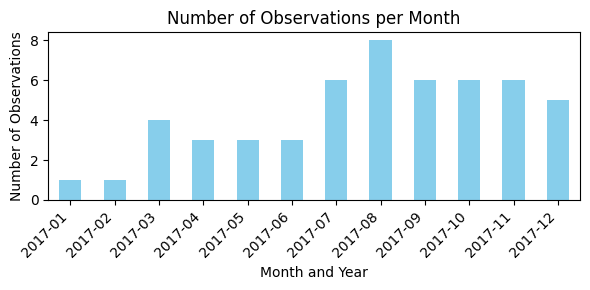

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Create a DataFrame and extract month and year
df = pd.DataFrame({'dates': dates})
df['month_year'] = df['dates'].dt.to_period('M')

# Count the occurrences
month_counts = df['month_year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(6, 3))
month_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Observations per Month')
plt.xlabel('Month and Year')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


Each of the following 17 plots represents the "spectral signature" for one sample over time for each of our 17 classes. X-axis represents the date, and Y-axis represents the DN values. Each line on a plot represents one channel over time. There is no legend as we do not know how channels correspond to original band from Sentinel, thus there is no need for their differentiation. The fluctuations in "DN" values (channel values) are noticeable across both time and different classes, indicating the dynamic nature of our data.

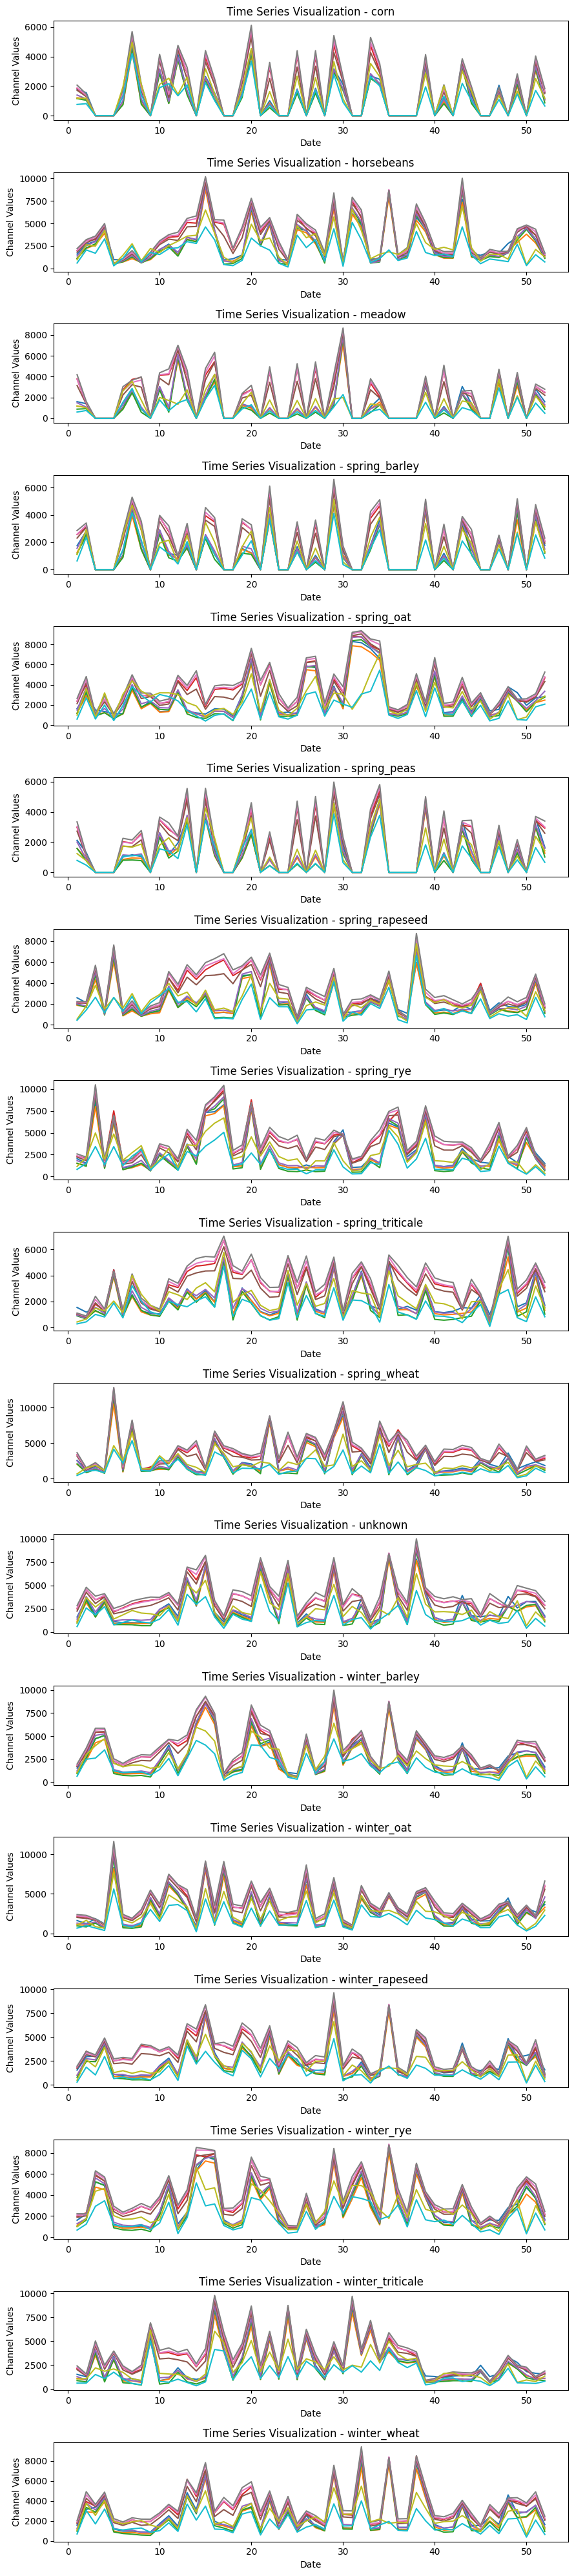

In [ ]:
# Create a dictionary mapping unique labels to class names
label_to_class = dict(zip(np.unique(labels), class_names))

# Plot one sample for each label
fig, axes = plt.subplots(nrows=17, figsize=(9, 40))

for i, label in enumerate(np.unique(labels)):
    # Find the index of the first sample belonging to the current label
    sample_index = next(index for index, l in enumerate(labels) if l == label)

    # Select the data for the first sample of the current label
    sample_data = series[sample_index, :, :]

    # Plotting on the corresponding subplot
    for channel_values in sample_data.T:
        axes[i].plot(range(1, 53), channel_values)

    axes[i].set_title(f'Time Series Visualization - {label_to_class[label]}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Channel Values')

plt.tight_layout()
plt.show()


To go further with our data characteristics, although we could generally assume these metrics based on the previous plots, let's calculate some standard statistic measures on a few flattened samples to illustrate volatile nature of our dataset.

We can see that there is a need for standardization as our data has different scales - among samples, all explanatory variables per one sample, among one channel over time per one sample, and among 10 channels per one timestamp.

In [ ]:
import numpy as np

# Assuming 'data' is your NumPy array
# Replace this with your actual data loading code

# Reshape the data to (60332, 520) for analysis
reshaped_data = series.reshape((60332, -1))

# Compute descriptive statistics
mean_values = np.mean(reshaped_data, axis=0)
std_dev_values = np.std(reshaped_data, axis=0)
min_values = np.min(reshaped_data, axis=0)
max_values = np.max(reshaped_data, axis=0)

# Display the results
for i in range(25):
    print(f"Sample {i + 1} - Mean: {mean_values[i]}, Std Dev: {std_dev_values[i]}, Min: {min_values[i]}, Max: {max_values[i]}")


Sample 1 - Mean: 2001.584795624473, Std Dev: 524.1380880572193, Min: 1309.5469798657718, Max: 4996.48
Sample 2 - Mean: 1497.2828610914685, Std Dev: 470.693399785299, Min: 790.853125, Max: 4142.426666666666
Sample 3 - Mean: 1434.6104953395832, Std Dev: 613.2997679888636, Min: 547.8865979381443, Max: 4987.312
Sample 4 - Mean: 2750.4823261875185, Std Dev: 822.3011436713897, Min: 399.7142857142857, Max: 6431.741496598639
Sample 5 - Mean: 1816.7989867081578, Std Dev: 639.919045494139, Min: 575.0840336134454, Max: 5536.416
Sample 6 - Mean: 2562.3296563097497, Std Dev: 779.471824532845, Min: 503.66386554621846, Max: 6296.809523809524
Sample 7 - Mean: 2834.9062600252973, Std Dev: 854.8738321217743, Min: 473.0504201680672, Max: 6679.102040816327
Sample 8 - Mean: 3060.4486969038335, Std Dev: 897.6457758737517, Min: 393.73949579831935, Max: 6940.380952380952
Sample 9 - Mean: 893.3558650426077, Std Dev: 237.05495089586955, Min: 121.91596638655462, Max: 7322.163841807909
Sample 10 - Mean: 567.38120

## Class distribution

Let's examine the distribution of our classes.

The first code block below prints absolute and relative counts of labels which correspond to our 17 classes. We can see that our classes are **not evenly distributed**. Some classes make more than 20% of total samples, but some less than 0.1%. The first code block below print absolute and relative counts of classes.

Here we see some problems. Firstly, label 13 has only one sample, and label 6 only 14 samples. I have decided to drop them. Secondly, labels are not represented by numbers in order, i.e. some numbers are missing, therefore this was overcome by making our labels contiguous.

First and second plots below show exacly the same results and we can view them as histograms.
  1. First plot shows Frequency of Classes. X-axis represents a class, and Y-axis represents its occurance.
  2. As our frequency of the classes is significantly different in scale, second plot shows exact information as the first one, but the frequency is logarithmically scaled.

Let's now assume that all classes are equally important. With this assumption in mind, having a class imbalance will negativaly impact our model prediction. This can be solved in two different ways: by data resamlping (or using ensemble methods) and during model training. Finally, accuracy metrics need to be cautiously choosen.


In [ ]:
# Calculate the absolute number and percentage of each class
unique_classes, class_counts = np.unique(labels, return_counts=True)
total_samples = len(labels)

class_percentages = class_counts / total_samples * 100

# Print the results
for class_label, count, percentage in zip(unique_classes, class_counts, class_percentages):
    print(f"Label {class_label}: Absolute Count: {count}, Percentage: {percentage:.2f}%")

Label 0: Absolute Count: 4047, Percentage: 6.71%
Label 1: Absolute Count: 318, Percentage: 0.53%
Label 2: Absolute Count: 12676, Percentage: 21.01%
Label 3: Absolute Count: 13838, Percentage: 22.94%
Label 4: Absolute Count: 1534, Percentage: 2.54%
Label 5: Absolute Count: 339, Percentage: 0.56%
Label 6: Absolute Count: 14, Percentage: 0.02%
Label 7: Absolute Count: 45, Percentage: 0.07%
Label 8: Absolute Count: 36, Percentage: 0.06%
Label 9: Absolute Count: 311, Percentage: 0.52%
Label 11: Absolute Count: 6413, Percentage: 10.63%
Label 12: Absolute Count: 3738, Percentage: 6.20%
Label 13: Absolute Count: 1, Percentage: 0.00%
Label 15: Absolute Count: 2917, Percentage: 4.83%
Label 16: Absolute Count: 3856, Percentage: 6.39%
Label 17: Absolute Count: 389, Percentage: 0.64%
Label 18: Absolute Count: 9860, Percentage: 16.34%


In [ ]:
# Identify the index of label 13 and 6 in unique labels
label_13_index = np.where(np.unique(labels) == 13)[0][0]
label_6_index = np.where(np.unique(labels) == 6)[0][0]
# Remove from class_names
class_names = np.delete(class_names, label_13_index)
class_names = np.delete(class_names, label_6_index)

# Remove label 13 and 6
series = np.delete(series, np.where(labels == 13), axis=0)
labels = np.delete(labels, np.where(labels == 13), axis=0)
series = np.delete(series, np.where(labels == 6), axis=0)
labels = np.delete(labels, np.where(labels == 6), axis=0)

print(series.shape, len(np.unique(labels)), class_names.shape)

(60317, 52, 10) 15 (15,)


In [ ]:
# Let's relabel our labels to be continous
print("Original Labels:", np.unique(labels))
# Make labels contiguous
unique_labels = np.unique(labels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}
labels = np.array([label_mapping[label] for label in labels])

print("Contiguous Labels:", np.unique(labels))

Original Labels: [ 0  1  2  3  4  5  7  8  9 11 12 15 16 17 18]
Contiguous Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


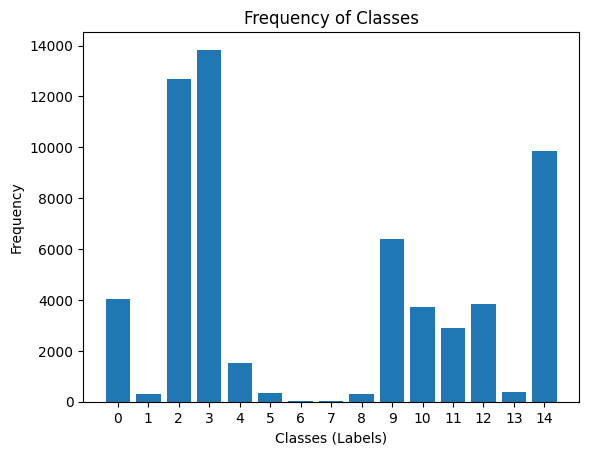

In [ ]:
# Calculate the absolute number and percentage of each class after relabeling
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Plotting a bar chart
plt.bar(unique_classes, class_counts)
plt.xticks(unique_classes)
plt.xlabel('Classes (Labels)')
plt.ylabel('Frequency')
plt.title('Frequency of Classes')
plt.show()

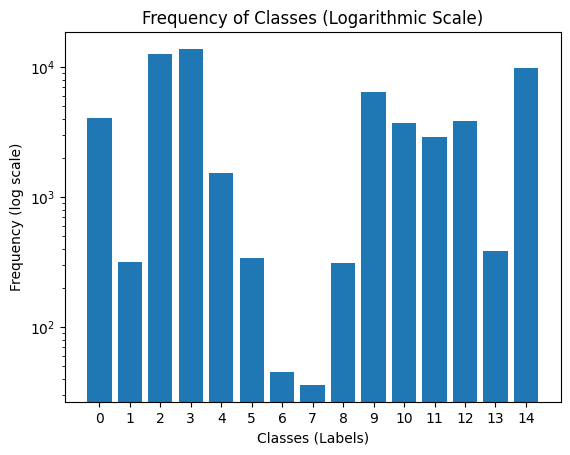

In [ ]:
# Plotting a bar chart with logarithmic scale
plt.bar(unique_classes, class_counts)
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.xticks(unique_classes)  # Set x-axis ticks to unique values
plt.xlabel('Classes (Labels)')
plt.ylabel('Frequency (log scale)')
plt.title('Frequency of Classes (Logarithmic Scale)')
plt.show()

In [ ]:
# Calculate the absolute number and percentage of each class
unique_classes, class_counts = np.unique(labels, return_counts=True)
total_samples = len(labels)

class_percentages = class_counts / total_samples * 100

# Print the results
for class_label, count, percentage in zip(unique_classes, class_counts, class_percentages):
    print(f"Label {class_label}: Absolute Count: {count}, Percentage: {percentage:.2f}%")

Label 0: Absolute Count: 4047, Percentage: 6.71%
Label 1: Absolute Count: 318, Percentage: 0.53%
Label 2: Absolute Count: 12676, Percentage: 21.02%
Label 3: Absolute Count: 13838, Percentage: 22.94%
Label 4: Absolute Count: 1534, Percentage: 2.54%
Label 5: Absolute Count: 339, Percentage: 0.56%
Label 6: Absolute Count: 45, Percentage: 0.07%
Label 7: Absolute Count: 36, Percentage: 0.06%
Label 8: Absolute Count: 311, Percentage: 0.52%
Label 9: Absolute Count: 6413, Percentage: 10.63%
Label 10: Absolute Count: 3738, Percentage: 6.20%
Label 11: Absolute Count: 2917, Percentage: 4.84%
Label 12: Absolute Count: 3856, Percentage: 6.39%
Label 13: Absolute Count: 389, Percentage: 0.64%
Label 14: Absolute Count: 9860, Percentage: 16.35%


# Data preparation

In this section we are going to discuss the best way of dealing with imbalanced dataset on a data level. Firstly, it is not possible to know whether data resampling will be positive for the accuracy until the model is trained and tested. Another important consideration is that we should only resample train dataset thus leaving test and evaluation set in a way that simulates real-world scenarios. Unfortunately, no sampling has happened and only the loss function is modifed.

In this section, dataset is scaled with MinMax scaler, split to 70/20/10 (thinking about imbalanced classes). Furthermore, dataset class is created in a way to return dataset based on a need of a model.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

num_samples, sequence_length, num_features = series.shape

# Reshape
series_2d = series.reshape((num_samples, sequence_length * num_features))

# Define range
scaling_range = (0, 1)

# Apply Min-Max scaler
minmax_scaler = MinMaxScaler(feature_range=scaling_range)
scaled_series_2d = minmax_scaler.fit_transform(series_2d)

# Reshape back to the original 3D array
scaled_series = scaled_series_2d.reshape((num_samples, sequence_length, num_features))

# Split 70/20/10
X_train, X_temp, y_train, y_temp = train_test_split(scaled_series, labels, test_size=0.3, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

# Check the split
def calculate_class_percentage(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_percentage = class_counts / len(labels)
    return dict(zip(unique_classes, class_percentage*100))

train_class_percentage = calculate_class_percentage(y_train)
valid_class_percentage = calculate_class_percentage(y_valid)
test_class_percentage = calculate_class_percentage(y_test)

print("Train Class Percentage:", train_class_percentage)
print("Validation Class Percentage:", valid_class_percentage)
print("Test Class Percentage:", test_class_percentage)



Train Class Percentage: {0: 6.709931076952228, 1: 0.5281731839605883, 2: 21.0156083465574, 3: 22.941190402880082, 4: 2.5437578456218466, 5: 0.5613320385590109, 6: 0.0734231780393643, 7: 0.05921224035432605, 8: 0.5163307358897231, 9: 10.632149878022785, 10: 6.19833732029085, 11: 4.836455792141352, 12: 6.392553468653039, 13: 0.6442291750550674, 14: 16.347315317022336}
Validation Class Percentage: {0: 6.7057076872319366, 1: 0.5278785879247773, 2: 21.016166281755197, 3: 22.946222368855164, 4: 2.5404157043879905, 5: 0.5608709996700759, 6: 0.08248102936324646, 7: 0.057736720554272515, 8: 0.511382382052128, 9: 10.631804684922468, 10: 6.194325305179809, 11: 4.833388320686242, 12: 6.392279775651601, 13: 0.651600131969647, 14: 16.34774001979545}
Test Class Percentage: {0: 6.714668452779639, 1: 0.5190890823844608, 2: 21.014735432016074, 3: 22.940388479571332, 4: 2.5452109845947755, 5: 0.5693235097119892, 6: 0.06697923643670461, 7: 0.06697923643670461, 8: 0.5190890823844608, 9: 10.632953784326858,

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


class CustomDataset(Dataset):
    def __init__(self, time_series_data, labels, input_type='mlp'):
        # Convert time series data and labels to PyTorch tensors
        self.time_series_data = torch.tensor(time_series_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.input_type = input_type

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        sample = {'label': self.labels[idx]}

        if self.input_type == 'mlp':
            # For MLP let's flatten the 3D tensor
            sample['data'] = self.time_series_data[idx].view(-1)
        elif self.input_type == 'rnn':
            # For RNN keep it #D
            sample['data'] = self.time_series_data[idx]
        elif self.input_type == 'cnn':
            # Transpose dimensions for CNN
            sample['data'] = self.time_series_data[idx].transpose(0, 1)
        else:
            raise ValueError("Invalid input_type. Supported types: 'mlp', 'rnn', 'cnn'.")

        return sample


# Create datasets for MLP
dataset_train_mlp = CustomDataset(X_train, y_train, input_type='mlp')
dataset_valid_mlp = CustomDataset(X_valid, y_valid, input_type='mlp')
dataset_test_mlp = CustomDataset(X_test, y_test, input_type='mlp')

# Create datasets for RNN
dataset_train_rnn = CustomDataset(X_train, y_train, input_type='rnn')
dataset_valid_rnn = CustomDataset(X_valid, y_valid, input_type='rnn')
dataset_test_rnn = CustomDataset(X_test, y_test, input_type='rnn')

# Create datasets for CNN
dataset_train_cnn = CustomDataset(X_train, y_train, input_type='cnn')
dataset_valid_cnn = CustomDataset(X_valid, y_valid, input_type='cnn')
dataset_test_cnn = CustomDataset(X_test, y_test, input_type='cnn')


# Models

In this section we are going to train and evaluate three models in two different scenarios. First scenario does not take into account class inbalance, but the second does.

I have checked that there are many other ways to handle imbalanced classes, but I did not have time to apply them in a meaningful way. Therefore, I have tried to make good predictions for classes with low number of samples by modifying loss function by weights based on a frequency (classes with lower number of samples to have more importance). That did not work well as well and I have commented accuracies in the Results section. More information about accuracies of each epoch are printed and plotted with the model training.

Hyperparameters are similar for every model, thus all of them are described here. As there are more models (and one of them is complex), not every hyperparameter was experimentally tuned many times.

### Hyperparameters
  - Some of the hyperparameters are defined by the shape of the dataset such as size of the input features of the network and output size i.e. number of all classes.
  - Number of hidden layers has been 64 as using 128 did not make a huge imporvement, but it is important for training time.
  - For dataloader: although data has various patterns, batch size is small as for the sake of having less time spent on trainin. Shuffle exists in the training set as we have assumed that the sequance of our samples does not show any relationship between them.
  - Training:
    - number of epochs was set to 25 unless it looked like there is a possibility that the model will learn better if there would be more of them. On top of that, there is an early stopping parameter to stop the training process if after 5 epochs there is no change in accuracy to not overfit it.
    - Cross Entropy loss was choosen for loss function as we have classification problem. Function was hypertuned by weights in the section with weighted NNs.
    - For optimization there was Adam and I have not tried any other optimizer function nor did I experiment with different learning rates and I would assume that the value of .001 worked good with no overshooting and small training time.
  - Finally, quite interesting and potentially important thing is that using Relu as an activation function for RNN lead to significantly lower accuracy, thus there is no activation function for this NN. For other two NNs, Relu was the only one used.

### Workflow
For each model we have a workflow as follows:

1) Define the model

2) Set up datasets and dataloader:

3) Initialize the model, loss function, and optimizer:

4) Start the training loop:

The training loop runs for a specified number of epochs. Within each epoch:
The model is set to training mode.
Training data is iterated through batches using the training DataLoader.
Loss is computed and backpropagation is performed to update model parameters.
Training time and loss per epoch are recorded.
The model is set to evaluation mode.
Validation data is used to evaluate the model's performance.
Validation accuracy, classification report, and F1 scores are printed.
The model is saved if it achieves a new best validation accuracy.
Early stopping is implemented based on validation performance.

5) Test on the best model

6) Calculate accuracy, classification report, and F1 scores

7) Plot the loss and the accuracies

## Unweighted

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import numpy as np

### MLP

Epoch 1/25, Loss: 1.3367, Validation Accuracy: 0.7091, Training Time: 2.46 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       813
           1       0.00      0.00      0.00        64
           2       0.74      0.93      0.82      2548
           3       0.70      0.92      0.80      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.64      0.25      0.35      1289
          10       0.80      0.50      0.61       751
          11       0.65      0.84      0.73       586
          12       0.60      0.19      0.29       775
          13       0.00      0.00      0.00        79
          14       0.70      0.86      0.77      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25, Loss: 0.8751, Validation Accuracy: 0.7562, Training Time: 2.41 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       813
           1       0.00      0.00      0.00        64
           2       0.84      0.87      0.85      2548
           3       0.75      0.91      0.82      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.60      0.49      0.54      1289
          10       0.80      0.69      0.74       751
          11       0.79      0.82      0.81       586
          12       0.57      0.38      0.46       775
          13       0.00      0.00      0.00        79
          14       0.74      0.90      0.81      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25, Loss: 0.7847, Validation Accuracy: 0.7688, Training Time: 2.41 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87       813
           1       1.00      0.05      0.09        64
           2       0.83      0.88      0.86      2548
           3       0.75      0.92      0.83      2782
           4       0.33      0.00      0.01       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.62      0.47      0.54      1289
          10       0.85      0.72      0.78       751
          11       0.90      0.78      0.83       586
          12       0.58      0.49      0.54       775
          13       0.00      0.00      0.00        79
          14       0.75      0.90      0.82      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/25, Loss: 0.7339, Validation Accuracy: 0.7802, Training Time: 2.73 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.84       813
           1       0.75      0.05      0.09        64
           2       0.77      0.95      0.85      2548
           3       0.78      0.91      0.84      2782
           4       0.16      0.01      0.02       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.63      0.46      0.53      1289
          10       0.79      0.86      0.83       751
          11       0.87      0.88      0.87       586
          12       0.67      0.52      0.59       775
          13       1.00      0.01      0.02        79
          14       0.83      0.87      0.85      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25, Loss: 0.6994, Validation Accuracy: 0.7953, Training Time: 3.22 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86       813
           1       0.82      0.22      0.35        64
           2       0.81      0.93      0.86      2548
           3       0.79      0.92      0.85      2782
           4       0.40      0.03      0.06       308
           5       0.25      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.71      0.43      0.54      1289
          10       0.85      0.84      0.84       751
          11       0.93      0.84      0.88       586
          12       0.67      0.61      0.64       775
          13       1.00      0.01      0.02        79
          14       0.81      0.90      0.85      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/25, Loss: 0.6763, Validation Accuracy: 0.7991, Training Time: 2.50 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88       813
           1       0.58      0.52      0.55        64
           2       0.81      0.93      0.87      2548
           3       0.80      0.92      0.86      2782
           4       0.50      0.05      0.09       308
           5       0.20      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.47      0.57      1289
          10       0.93      0.75      0.83       751
          11       0.94      0.82      0.88       586
          12       0.65      0.59      0.62       775
          13       1.00      0.03      0.05        79
          14       0.79      0.92      0.85      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25, Loss: 0.6523, Validation Accuracy: 0.8058, Training Time: 2.41 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88       813
           1       0.59      0.47      0.52        64
           2       0.82      0.92      0.87      2548
           3       0.80      0.92      0.86      2782
           4       0.41      0.06      0.10       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.74      0.46      0.57      1289
          10       0.90      0.83      0.86       751
          11       0.92      0.88      0.90       586
          12       0.66      0.67      0.66       775
          13       0.67      0.03      0.05        79
          14       0.82      0.91      0.86      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/25, Loss: 0.6350, Validation Accuracy: 0.8063, Training Time: 2.42 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.89       813
           1       0.69      0.28      0.40        64
           2       0.83      0.92      0.87      2548
           3       0.76      0.94      0.84      2782
           4       0.67      0.01      0.03       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.76      0.47      0.58      1289
          10       0.77      0.95      0.85       751
          11       0.83      0.95      0.89       586
          12       0.73      0.60      0.66       775
          13       0.50      0.03      0.05        79
          14       0.89      0.86      0.87      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/25, Loss: 0.6179, Validation Accuracy: 0.8137, Training Time: 2.60 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       813
           1       0.86      0.30      0.44        64
           2       0.84      0.90      0.87      2548
           3       0.76      0.94      0.84      2782
           4       0.50      0.02      0.04       308
           5       0.20      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.52      0.61      1289
          10       0.91      0.86      0.89       751
          11       0.93      0.94      0.93       586
          12       0.66      0.78      0.72       775
          13       0.67      0.05      0.09        79
          14       0.90      0.85      0.88      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/25, Loss: 0.6073, Validation Accuracy: 0.8196, Training Time: 3.26 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       813
           1       0.78      0.39      0.52        64
           2       0.82      0.92      0.87      2548
           3       0.80      0.93      0.86      2782
           4       0.52      0.04      0.07       308
           5       0.50      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.50      0.59      1289
          10       0.86      0.92      0.89       751
          11       0.85      0.96      0.91       586
          12       0.77      0.66      0.71       775
          13       0.67      0.05      0.09        79
          14       0.88      0.90      0.89      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/25, Loss: 0.5932, Validation Accuracy: 0.8119, Training Time: 2.56 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       813
           1       0.54      0.52      0.53        64
           2       0.84      0.90      0.87      2548
           3       0.82      0.91      0.86      2782
           4       0.53      0.03      0.05       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.67      0.60      0.63      1289
          10       0.86      0.90      0.88       751
          11       0.84      0.97      0.90       586
          12       0.82      0.48      0.61       775
          13       0.58      0.09      0.15        79
          14       0.83      0.91      0.87      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/25, Loss: 0.5823, Validation Accuracy: 0.8209, Training Time: 2.47 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       813
           1       0.95      0.28      0.43        64
           2       0.87      0.86      0.87      2548
           3       0.78      0.94      0.85      2782
           4       0.41      0.06      0.10       308
           5       1.00      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.65      0.65      0.65      1289
          10       0.87      0.91      0.89       751
          11       0.96      0.91      0.94       586
          12       0.71      0.80      0.75       775
          13       0.67      0.10      0.18        79
          14       0.91      0.85      0.88      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/25, Loss: 0.5722, Validation Accuracy: 0.8204, Training Time: 2.39 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       813
           1       0.74      0.36      0.48        64
           2       0.79      0.95      0.86      2548
           3       0.81      0.93      0.86      2782
           4       0.75      0.02      0.04       308
           5       1.00      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.74      0.55      0.63      1289
          10       0.86      0.91      0.89       751
          11       0.95      0.93      0.94       586
          12       0.84      0.54      0.66       775
          13       0.34      0.18      0.23        79
          14       0.84      0.92      0.88      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/25, Loss: 0.5623, Validation Accuracy: 0.8301, Training Time: 2.69 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       813
           1       0.62      0.53      0.57        64
           2       0.80      0.94      0.87      2548
           3       0.81      0.93      0.87      2782
           4       0.64      0.05      0.10       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.75      0.55      0.64      1289
          10       0.88      0.91      0.89       751
          11       0.97      0.92      0.94       586
          12       0.74      0.75      0.75       775
          13       0.53      0.23      0.32        79
          14       0.90      0.88      0.89      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/25, Loss: 0.5552, Validation Accuracy: 0.8242, Training Time: 3.23 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       813
           1       0.65      0.50      0.57        64
           2       0.83      0.93      0.88      2548
           3       0.80      0.93      0.86      2782
           4       0.65      0.04      0.07       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.76      0.55      0.64      1289
          10       0.76      0.96      0.85       751
          11       0.83      0.98      0.90       586
          12       0.82      0.62      0.70       775
          13       0.36      0.15      0.21        79
          14       0.91      0.87      0.89      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/25, Loss: 0.5520, Validation Accuracy: 0.8331, Training Time: 2.57 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       813
           1       0.48      0.62      0.54        64
           2       0.85      0.91      0.88      2548
           3       0.82      0.92      0.87      2782
           4       0.55      0.09      0.16       308
           5       0.25      0.03      0.05        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.59      0.65      1289
          10       0.92      0.89      0.91       751
          11       0.95      0.94      0.94       586
          12       0.74      0.75      0.74       775
          13       0.78      0.09      0.16        79
          14       0.86      0.92      0.89      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/25, Loss: 0.5434, Validation Accuracy: 0.8368, Training Time: 2.42 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       813
           1       0.71      0.42      0.53        64
           2       0.84      0.93      0.88      2548
           3       0.82      0.93      0.87      2782
           4       0.51      0.14      0.21       308
           5       0.28      0.07      0.12        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.76      0.56      0.64      1289
          10       0.82      0.96      0.88       751
          11       0.94      0.96      0.95       586
          12       0.77      0.78      0.77       775
          13       0.47      0.20      0.28        79
          14       0.92      0.87      0.90      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/25, Loss: 0.5378, Validation Accuracy: 0.8307, Training Time: 2.39 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       813
           1       0.66      0.52      0.58        64
           2       0.83      0.93      0.88      2548
           3       0.82      0.92      0.87      2782
           4       0.69      0.03      0.06       308
           5       0.25      0.04      0.07        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.71      0.62      0.66      1289
          10       0.88      0.93      0.91       751
          11       0.83      0.98      0.90       586
          12       0.86      0.60      0.70       775
          13       0.73      0.10      0.18        79
          14       0.87      0.92      0.89      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/25, Loss: 0.5321, Validation Accuracy: 0.8307, Training Time: 2.66 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       813
           1       0.95      0.31      0.47        64
           2       0.86      0.90      0.88      2548
           3       0.79      0.94      0.86      2782
           4       0.50      0.05      0.09       308
           5       1.00      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.77      0.58      0.66      1289
          10       0.90      0.91      0.90       751
          11       0.92      0.97      0.94       586
          12       0.83      0.61      0.70       775
          13       0.67      0.13      0.21        79
          14       0.83      0.94      0.88      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/25, Loss: 0.5226, Validation Accuracy: 0.8316, Training Time: 3.20 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       813
           1       0.78      0.45      0.57        64
           2       0.86      0.90      0.88      2548
           3       0.81      0.92      0.86      2782
           4       0.65      0.06      0.10       308
           5       1.00      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.77      0.59      0.67      1289
          10       0.89      0.90      0.90       751
          11       0.98      0.90      0.94       586
          12       0.75      0.71      0.73       775
          13       0.67      0.08      0.14        79
          14       0.81      0.95      0.88      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/25, Loss: 0.5204, Validation Accuracy: 0.8310, Training Time: 2.50 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       813
           1       0.66      0.55      0.60        64
           2       0.84      0.92      0.88      2548
           3       0.82      0.93      0.87      2782
           4       0.55      0.10      0.17       308
           5       1.00      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.80      0.52      0.63      1289
          10       0.91      0.90      0.90       751
          11       0.99      0.86      0.92       586
          12       0.66      0.86      0.75       775
          13       0.71      0.13      0.22        79
          14       0.90      0.89      0.90      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/25, Loss: 0.5137, Validation Accuracy: 0.8429, Training Time: 2.40 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       813
           1       0.91      0.45      0.60        64
           2       0.86      0.90      0.88      2548
           3       0.82      0.93      0.87      2782
           4       0.55      0.07      0.13       308
           5       0.33      0.03      0.05        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.76      0.62      0.68      1289
          10       0.90      0.92      0.91       751
          11       0.96      0.96      0.96       586
          12       0.76      0.79      0.77       775
          13       0.55      0.20      0.30        79
          14       0.88      0.92      0.90      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/25, Loss: 0.5130, Validation Accuracy: 0.8482, Training Time: 2.46 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       813
           1       0.66      0.52      0.58        64
           2       0.86      0.91      0.88      2548
           3       0.84      0.92      0.88      2782
           4       0.52      0.21      0.30       308
           5       1.00      0.03      0.06        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.66      0.69      1289
          10       0.92      0.92      0.92       751
          11       0.92      0.98      0.95       586
          12       0.79      0.78      0.79       775
          13       0.67      0.15      0.25        79
          14       0.89      0.92      0.91      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/25, Loss: 0.5046, Validation Accuracy: 0.8394, Training Time: 2.63 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       813
           1       0.71      0.50      0.59        64
           2       0.90      0.85      0.87      2548
           3       0.83      0.92      0.87      2782
           4       0.44      0.24      0.31       308
           5       0.67      0.03      0.06        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.50      0.03      0.06        62
           9       0.71      0.68      0.70      1289
          10       0.90      0.91      0.91       751
          11       0.97      0.93      0.95       586
          12       0.72      0.81      0.76       775
          13       0.65      0.14      0.23        79
          14       0.87      0.93      0.90      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/25, Loss: 0.5001, Validation Accuracy: 0.8402, Training Time: 3.26 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       813
           1       0.78      0.39      0.52        64
           2       0.85      0.92      0.88      2548
           3       0.83      0.93      0.88      2782
           4       0.68      0.09      0.16       308
           5       0.67      0.06      0.11        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.20      0.02      0.03        62
           9       0.72      0.64      0.68      1289
          10       0.79      0.96      0.87       751
          11       0.96      0.95      0.96       586
          12       0.83      0.69      0.75       775
          13       0.56      0.13      0.21        79
          14       0.88      0.93      0.90      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test Results
Test Accuracy: 0.8413
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93       401
           1       0.73      0.35      0.48        31
           2       0.85      0.92      0.89      1255
           3       0.82      0.93      0.87      1370
           4       0.46      0.08      0.13       152
           5       0.67      0.12      0.20        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.73      0.66      0.69       635
          10       0.80      0.97      0.88       370
          11       0.95      0.97      0.96       289
          12       0.83      0.65      0.73       382
          13       0.86      0.16      0.27        38
          14       0.88      0.92      0.90       976

    accuracy                           0.84      5972
   macro avg    

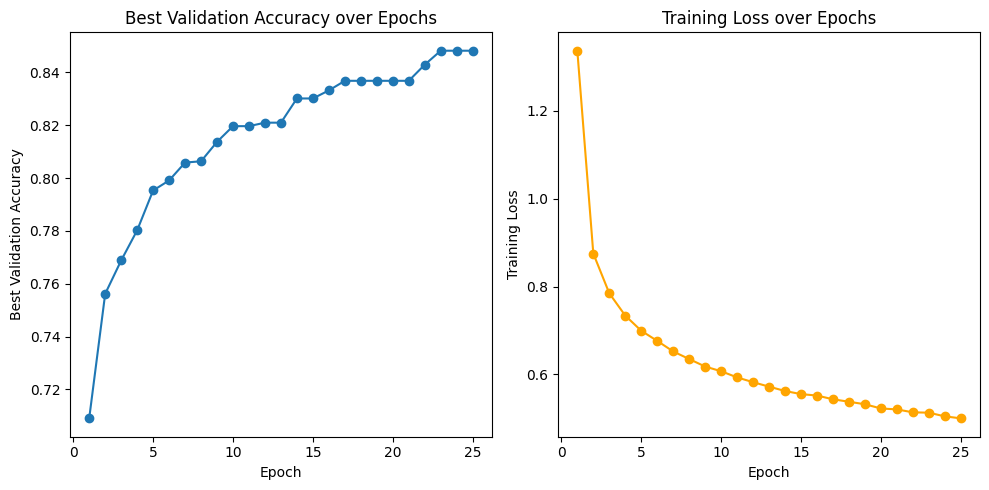

In [ ]:
# Define MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Datasets and Dataloader
num_samples, sequence_length, num_features = X_train.shape
input_size = sequence_length * num_features
hidden_size = 64
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='mlp')
dataset_valid = CustomDataset(X_valid, y_valid, input_type='mlp')

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MLPModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

# Variable for the best model
best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)  # Average loss per batch

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for testing
dataset_test = CustomDataset(X_test, y_test, input_type='mlp')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")


## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

### RNN

Epoch 1/25, Loss: 2.1071, Validation Accuracy: 0.2361, Training Time: 236.63 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.00      0.00      0.00        64
           2       0.24      0.91      0.38      2548
           3       0.23      0.20      0.21      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.00      0.00      0.00      1289
          10       0.00      0.00      0.00       751
          11       0.00      0.00      0.00       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.00      0.00      0.00      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25, Loss: 2.0857, Validation Accuracy: 0.2811, Training Time: 233.82 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.00      0.00      0.00        64
           2       0.32      0.69      0.44      2548
           3       0.23      0.51      0.32      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.00      0.00      0.00      1289
          10       0.00      0.00      0.00       751
          11       0.00      0.00      0.00       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.48      0.11      0.18      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25, Loss: 1.9207, Validation Accuracy: 0.4446, Training Time: 238.93 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.00      0.00      0.00        64
           2       0.88      0.50      0.64      2548
           3       0.47      0.93      0.62      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.00      0.00      0.00      1289
          10       0.50      0.00      0.00       751
          11       0.00      0.00      0.00       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.30      0.76      0.43      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/25, Loss: 1.3438, Validation Accuracy: 0.6415, Training Time: 234.27 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.63      0.68       813
           1       0.00      0.00      0.00        64
           2       0.70      0.93      0.80      2548
           3       0.78      0.76      0.77      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.33      0.24      0.28      1289
          10       0.67      0.63      0.65       751
          11       0.51      0.47      0.49       586
          12       0.23      0.01      0.02       775
          13       0.00      0.00      0.00        79
          14       0.55      0.86      0.67      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25, Loss: 0.9642, Validation Accuracy: 0.7083, Training Time: 232.39 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       813
           1       0.00      0.00      0.00        64
           2       0.81      0.83      0.82      2548
           3       0.81      0.86      0.84      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.46      0.47      0.46      1289
          10       0.60      0.80      0.69       751
          11       0.80      0.70      0.74       586
          12       0.34      0.10      0.15       775
          13       0.00      0.00      0.00        79
          14       0.65      0.91      0.76      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/25, Loss: 0.8621, Validation Accuracy: 0.7256, Training Time: 236.32 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       813
           1       0.00      0.00      0.00        64
           2       0.75      0.91      0.82      2548
           3       0.77      0.92      0.84      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.58      0.34      0.43      1289
          10       0.89      0.40      0.56       751
          11       0.73      0.82      0.77       586
          12       0.38      0.44      0.41       775
          13       0.00      0.00      0.00        79
          14       0.76      0.84      0.80      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25, Loss: 0.8099, Validation Accuracy: 0.7191, Training Time: 229.92 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       813
           1       0.00      0.00      0.00        64
           2       0.71      0.94      0.81      2548
           3       0.81      0.88      0.85      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.58      0.29      0.39      1289
          10       0.83      0.59      0.69       751
          11       0.60      0.89      0.71       586
          12       0.39      0.45      0.42       775
          13       0.00      0.00      0.00        79
          14       0.82      0.73      0.77      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/25, Loss: 0.7732, Validation Accuracy: 0.7474, Training Time: 228.71 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       813
           1       0.00      0.00      0.00        64
           2       0.84      0.83      0.83      2548
           3       0.76      0.95      0.84      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.63      0.45      0.52      1289
          10       0.54      0.90      0.68       751
          11       0.82      0.78      0.80       586
          12       0.51      0.27      0.36       775
          13       0.00      0.00      0.00        79
          14       0.79      0.85      0.82      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/25, Loss: 0.7485, Validation Accuracy: 0.7305, Training Time: 230.21 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       813
           1       0.33      0.08      0.13        64
           2       0.83      0.82      0.82      2548
           3       0.78      0.93      0.85      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.59      0.45      0.51      1289
          10       0.51      0.92      0.66       751
          11       0.82      0.74      0.78       586
          12       0.33      0.12      0.18       775
          13       0.00      0.00      0.00        79
          14       0.72      0.87      0.79      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/25, Loss: 0.7241, Validation Accuracy: 0.7635, Training Time: 239.11 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       813
           1       0.67      0.28      0.40        64
           2       0.80      0.88      0.84      2548
           3       0.79      0.94      0.86      2782
           4       0.29      0.01      0.01       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.62      0.52      0.57      1289
          10       0.66      0.85      0.74       751
          11       0.90      0.68      0.77       586
          12       0.46      0.50      0.48       775
          13       0.00      0.00      0.00        79
          14       0.87      0.77      0.81      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/25, Loss: 0.7050, Validation Accuracy: 0.7725, Training Time: 236.77 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       813
           1       0.56      0.36      0.44        64
           2       0.88      0.79      0.83      2548
           3       0.79      0.95      0.86      2782
           4       0.20      0.00      0.01       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.57      0.61      0.59      1289
          10       0.78      0.84      0.81       751
          11       0.87      0.79      0.83       586
          12       0.52      0.46      0.49       775
          13       0.00      0.00      0.00        79
          14       0.79      0.90      0.84      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/25, Loss: 0.6836, Validation Accuracy: 0.7734, Training Time: 235.20 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       813
           1       0.67      0.19      0.29        64
           2       0.83      0.86      0.84      2548
           3       0.82      0.89      0.85      2782
           4       0.29      0.05      0.08       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.59      0.59      0.59      1289
          10       0.82      0.79      0.80       751
          11       0.81      0.88      0.85       586
          12       0.50      0.63      0.56       775
          13       0.00      0.00      0.00        79
          14       0.83      0.81      0.82      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/25, Loss: 0.6635, Validation Accuracy: 0.7851, Training Time: 230.88 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       813
           1       0.55      0.42      0.48        64
           2       0.88      0.80      0.84      2548
           3       0.79      0.95      0.86      2782
           4       0.22      0.01      0.01       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.59      0.62      0.61      1289
          10       0.87      0.81      0.84       751
          11       0.92      0.74      0.82       586
          12       0.54      0.65      0.59       775
          13       0.00      0.00      0.00        79
          14       0.82      0.87      0.85      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/25, Loss: 0.6522, Validation Accuracy: 0.7886, Training Time: 226.53 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       813
           1       0.48      0.31      0.38        64
           2       0.84      0.87      0.86      2548
           3       0.82      0.93      0.87      2782
           4       0.45      0.03      0.05       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.60      0.60      0.60      1289
          10       0.73      0.85      0.79       751
          11       0.92      0.79      0.85       586
          12       0.57      0.55      0.56       775
          13       0.00      0.00      0.00        79
          14       0.86      0.84      0.85      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/25, Loss: 0.6339, Validation Accuracy: 0.7965, Training Time: 231.01 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       813
           1       0.67      0.34      0.45        64
           2       0.86      0.85      0.85      2548
           3       0.80      0.94      0.87      2782
           4       0.41      0.04      0.07       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.63      0.61      0.62      1289
          10       0.89      0.79      0.84       751
          11       0.87      0.90      0.88       586
          12       0.63      0.54      0.58       775
          13       0.00      0.00      0.00        79
          14       0.80      0.90      0.84      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/25, Loss: 0.6151, Validation Accuracy: 0.8007, Training Time: 228.39 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       813
           1       0.50      0.58      0.54        64
           2       0.86      0.88      0.87      2548
           3       0.81      0.93      0.86      2782
           4       0.51      0.09      0.15       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.67      0.61      0.64      1289
          10       0.92      0.76      0.83       751
          11       0.88      0.89      0.89       586
          12       0.63      0.52      0.57       775
          13       0.00      0.00      0.00        79
          14       0.79      0.90      0.84      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/25, Loss: 0.6050, Validation Accuracy: 0.8069, Training Time: 228.64 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       813
           1       0.56      0.47      0.51        64
           2       0.85      0.89      0.87      2548
           3       0.83      0.93      0.87      2782
           4       0.43      0.09      0.15       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.64      0.62      0.63      1289
          10       0.87      0.85      0.86       751
          11       0.91      0.87      0.89       586
          12       0.69      0.47      0.56       775
          13       0.00      0.00      0.00        79
          14       0.78      0.94      0.85      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/25, Loss: 0.5901, Validation Accuracy: 0.8170, Training Time: 229.27 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       813
           1       0.78      0.33      0.46        64
           2       0.83      0.91      0.87      2548
           3       0.80      0.95      0.87      2782
           4       0.40      0.02      0.04       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.55      0.63      1289
          10       0.88      0.88      0.88       751
          11       0.90      0.91      0.91       586
          12       0.63      0.68      0.65       775
          13       0.00      0.00      0.00        79
          14       0.86      0.88      0.87      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/25, Loss: 0.5797, Validation Accuracy: 0.8080, Training Time: 231.58 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       813
           1       0.54      0.52      0.53        64
           2       0.86      0.88      0.87      2548
           3       0.83      0.92      0.87      2782
           4       0.41      0.23      0.29       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.76      0.56      0.64      1289
          10       0.82      0.87      0.85       751
          11       0.94      0.84      0.89       586
          12       0.61      0.55      0.58       775
          13       0.00      0.00      0.00        79
          14       0.79      0.93      0.85      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/25, Loss: 0.5700, Validation Accuracy: 0.8200, Training Time: 229.22 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       813
           1       0.60      0.52      0.55        64
           2       0.81      0.93      0.87      2548
           3       0.82      0.94      0.88      2782
           4       0.65      0.08      0.15       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.75      0.55      0.64      1289
          10       0.88      0.89      0.88       751
          11       0.94      0.88      0.91       586
          12       0.68      0.59      0.63       775
          13       0.00      0.00      0.00        79
          14       0.84      0.90      0.87      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/25, Loss: 0.5609, Validation Accuracy: 0.8179, Training Time: 233.68 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       813
           1       0.67      0.38      0.48        64
           2       0.84      0.91      0.87      2548
           3       0.82      0.93      0.87      2782
           4       0.53      0.06      0.10       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.73      0.56      0.63      1289
          10       0.91      0.85      0.88       751
          11       0.94      0.86      0.90       586
          12       0.60      0.74      0.66       775
          13       0.00      0.00      0.00        79
          14       0.86      0.89      0.87      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/25, Loss: 0.5511, Validation Accuracy: 0.8180, Training Time: 243.86 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       813
           1       0.67      0.53      0.59        64
           2       0.84      0.92      0.88      2548
           3       0.83      0.94      0.88      2782
           4       0.46      0.15      0.23       308
           5       0.17      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.80      0.53      0.64      1289
          10       0.69      0.95      0.80       751
          11       0.91      0.92      0.92       586
          12       0.64      0.66      0.65       775
          13       0.00      0.00      0.00        79
          14       0.90      0.84      0.87      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/25, Loss: 0.5424, Validation Accuracy: 0.8293, Training Time: 235.71 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       813
           1       0.67      0.56      0.61        64
           2       0.85      0.91      0.88      2548
           3       0.83      0.94      0.88      2782
           4       0.49      0.12      0.20       308
           5       0.33      0.01      0.03        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.77      0.56      0.65      1289
          10       0.87      0.91      0.89       751
          11       0.92      0.94      0.93       586
          12       0.71      0.61      0.66       775
          13       0.50      0.01      0.02        79
          14       0.83      0.93      0.88      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/25, Loss: 0.5330, Validation Accuracy: 0.8264, Training Time: 227.34 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       813
           1       0.71      0.45      0.55        64
           2       0.82      0.94      0.88      2548
           3       0.83      0.92      0.87      2782
           4       0.51      0.12      0.20       308
           5       0.22      0.03      0.05        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.79      0.55      0.64      1289
          10       0.91      0.87      0.89       751
          11       0.95      0.92      0.93       586
          12       0.62      0.78      0.69       775
          13       0.00      0.00      0.00        79
          14       0.86      0.89      0.87      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/25, Loss: 0.5279, Validation Accuracy: 0.8212, Training Time: 231.32 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       813
           1       0.62      0.56      0.59        64
           2       0.82      0.94      0.88      2548
           3       0.84      0.93      0.88      2782
           4       0.56      0.15      0.24       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.79      0.55      0.65      1289
          10       0.83      0.94      0.88       751
          11       0.98      0.76      0.86       586
          12       0.60      0.78      0.68       775
          13       0.00      0.00      0.00        79
          14       0.89      0.84      0.86      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test Results
Test Accuracy: 0.8289
Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       401
           1       0.73      0.61      0.67        31
           2       0.82      0.95      0.88      1255
           3       0.83      0.93      0.88      1370
           4       0.65      0.17      0.27       152
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.80      0.57      0.66       635
          10       0.84      0.95      0.90       370
          11       0.99      0.78      0.87       289
          12       0.62      0.78      0.69       382
          13       0.00      0.00      0.00        38
          14       0.89      0.84      0.87       976

    accuracy                           0.83      5972
   macro avg    

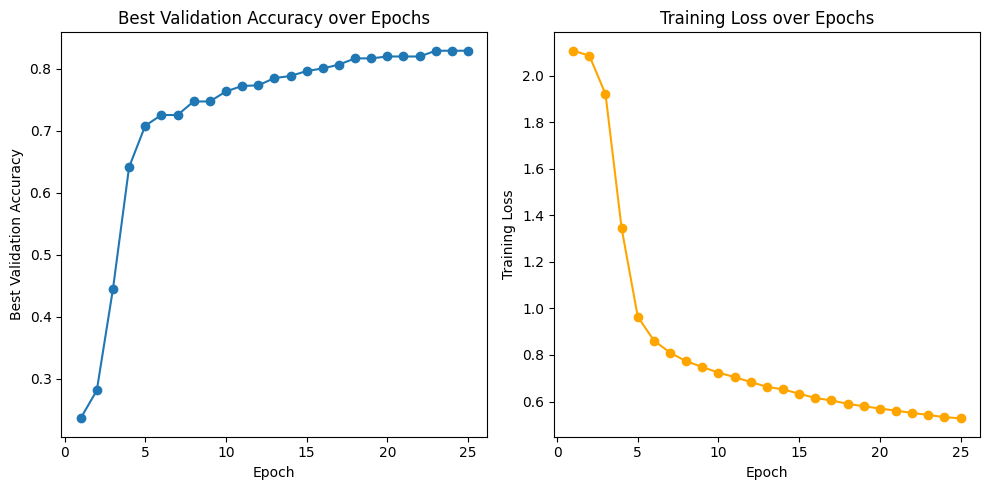

In [ ]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use only the output from the last time step
        return output

# Set up datasets and DataLoader
num_samples, sequence_length, num_features = X_train.shape
input_size = num_samples
hidden_size = 64
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='rnn')
dataset_valid = CustomDataset(X_valid, y_valid, input_type='rnn')

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize your model, loss function, and optimizer
model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=1, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model state for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for the test set
dataset_test = CustomDataset(X_test, y_test, input_type='rnn')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")

## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

### 1D CNN

Epoch 1/25, Loss: 1.9851, Validation Accuracy: 0.4454, Training Time: 3.78 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.00      0.00      0.00        64
           2       0.51      0.84      0.63      2548
           3       0.42      0.90      0.57      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.00      0.00      0.00      1289
          10       0.00      0.00      0.00       751
          11       0.00      0.00      0.00       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.39      0.38      0.38      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25, Loss: 1.6185, Validation Accuracy: 0.5306, Training Time: 3.65 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.01      0.02       813
           1       0.00      0.00      0.00        64
           2       0.58      0.91      0.71      2548
           3       0.50      0.87      0.64      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.30      0.02      0.04      1289
          10       0.46      0.30      0.36       751
          11       0.91      0.09      0.16       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.53      0.69      0.60      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25, Loss: 1.4456, Validation Accuracy: 0.5691, Training Time: 6.65 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.10      0.17       813
           1       0.00      0.00      0.00        64
           2       0.68      0.89      0.77      2548
           3       0.51      0.88      0.65      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.31      0.09      0.14      1289
          10       0.57      0.34      0.43       751
          11       0.72      0.46      0.56       586
          12       0.19      0.01      0.01       775
          13       0.00      0.00      0.00        79
          14       0.56      0.73      0.63      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/25, Loss: 1.3363, Validation Accuracy: 0.5954, Training Time: 5.74 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.12      0.20       813
           1       0.00      0.00      0.00        64
           2       0.69      0.92      0.78      2548
           3       0.56      0.85      0.67      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.30      0.18      0.22      1289
          10       0.64      0.33      0.43       751
          11       0.71      0.59      0.65       586
          12       0.36      0.05      0.08       775
          13       0.00      0.00      0.00        79
          14       0.60      0.79      0.68      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25, Loss: 1.2537, Validation Accuracy: 0.6144, Training Time: 3.91 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.27      0.39       813
           1       0.00      0.00      0.00        64
           2       0.69      0.93      0.79      2548
           3       0.62      0.80      0.70      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.35      0.17      0.23      1289
          10       0.68      0.38      0.48       751
          11       0.73      0.64      0.68       586
          12       0.36      0.02      0.04       775
          13       0.00      0.00      0.00        79
          14       0.55      0.88      0.68      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/25, Loss: 1.1902, Validation Accuracy: 0.6269, Training Time: 4.83 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.22      0.34       813
           1       0.00      0.00      0.00        64
           2       0.72      0.92      0.81      2548
           3       0.59      0.85      0.70      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.42      0.13      0.20      1289
          10       0.63      0.45      0.53       751
          11       0.82      0.63      0.71       586
          12       0.36      0.10      0.16       775
          13       0.00      0.00      0.00        79
          14       0.58      0.88      0.70      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25, Loss: 1.1388, Validation Accuracy: 0.6538, Training Time: 3.64 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.44      0.53       813
           1       0.00      0.00      0.00        64
           2       0.76      0.90      0.83      2548
           3       0.63      0.85      0.73      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.40      0.20      0.27      1289
          10       0.64      0.52      0.57       751
          11       0.77      0.80      0.78       586
          12       0.44      0.09      0.15       775
          13       0.00      0.00      0.00        79
          14       0.61      0.87      0.72      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/25, Loss: 1.0945, Validation Accuracy: 0.6540, Training Time: 4.52 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.36      0.48       813
           1       0.00      0.00      0.00        64
           2       0.73      0.93      0.81      2548
           3       0.61      0.88      0.72      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.40      0.20      0.27      1289
          10       0.76      0.39      0.52       751
          11       0.84      0.79      0.81       586
          12       0.44      0.16      0.23       775
          13       0.00      0.00      0.00        79
          14       0.64      0.86      0.74      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/25, Loss: 1.0578, Validation Accuracy: 0.6720, Training Time: 5.78 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.44      0.55       813
           1       0.00      0.00      0.00        64
           2       0.75      0.92      0.83      2548
           3       0.64      0.86      0.74      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.44      0.22      0.30      1289
          10       0.59      0.65      0.62       751
          11       0.87      0.82      0.85       586
          12       0.50      0.10      0.17       775
          13       0.00      0.00      0.00        79
          14       0.66      0.86      0.75      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/25, Loss: 1.0235, Validation Accuracy: 0.6823, Training Time: 4.51 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.64       813
           1       0.00      0.00      0.00        64
           2       0.74      0.93      0.82      2548
           3       0.69      0.84      0.75      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.46      0.22      0.29      1289
          10       0.64      0.62      0.63       751
          11       0.87      0.86      0.86       586
          12       0.47      0.11      0.18       775
          13       0.00      0.00      0.00        79
          14       0.64      0.90      0.75      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/25, Loss: 0.9934, Validation Accuracy: 0.6918, Training Time: 7.23 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.50      0.61       813
           1       0.00      0.00      0.00        64
           2       0.75      0.93      0.83      2548
           3       0.68      0.85      0.76      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.49      0.23      0.31      1289
          10       0.63      0.67      0.65       751
          11       0.90      0.86      0.88       586
          12       0.49      0.25      0.33       775
          13       0.00      0.00      0.00        79
          14       0.67      0.88      0.76      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/25, Loss: 0.9653, Validation Accuracy: 0.7018, Training Time: 4.81 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68       813
           1       0.00      0.00      0.00        64
           2       0.79      0.90      0.84      2548
           3       0.72      0.81      0.77      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.45      0.33      0.38      1289
          10       0.79      0.53      0.64       751
          11       0.86      0.92      0.89       586
          12       0.46      0.39      0.42       775
          13       0.00      0.00      0.00        79
          14       0.70      0.87      0.77      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/25, Loss: 0.9395, Validation Accuracy: 0.7038, Training Time: 4.57 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.51      0.63       813
           1       0.00      0.00      0.00        64
           2       0.77      0.92      0.84      2548
           3       0.66      0.90      0.76      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.51      0.25      0.34      1289
          10       0.74      0.62      0.67       751
          11       0.93      0.88      0.91       586
          12       0.50      0.32      0.39       775
          13       0.00      0.00      0.00        79
          14       0.70      0.88      0.78      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/25, Loss: 0.9153, Validation Accuracy: 0.7135, Training Time: 6.77 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       813
           1       0.00      0.00      0.00        64
           2       0.76      0.93      0.83      2548
           3       0.72      0.85      0.78      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.53      0.29      0.37      1289
          10       0.77      0.60      0.67       751
          11       0.94      0.89      0.91       586
          12       0.52      0.27      0.35       775
          13       0.00      0.00      0.00        79
          14       0.67      0.90      0.77      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/25, Loss: 0.8940, Validation Accuracy: 0.7188, Training Time: 4.37 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       813
           1       0.00      0.00      0.00        64
           2       0.77      0.92      0.84      2548
           3       0.68      0.90      0.77      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.58      0.27      0.37      1289
          10       0.80      0.59      0.68       751
          11       0.92      0.92      0.92       586
          12       0.52      0.30      0.38       775
          13       0.00      0.00      0.00        79
          14       0.70      0.89      0.78      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/25, Loss: 0.8730, Validation Accuracy: 0.7227, Training Time: 4.62 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73       813
           1       0.00      0.00      0.00        64
           2       0.76      0.93      0.84      2548
           3       0.69      0.90      0.78      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.60      0.28      0.38      1289
          10       0.74      0.67      0.70       751
          11       0.94      0.91      0.92       586
          12       0.56      0.21      0.31       775
          13       0.00      0.00      0.00        79
          14       0.69      0.91      0.78      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/25, Loss: 0.8546, Validation Accuracy: 0.7278, Training Time: 6.57 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.61      0.71       813
           1       0.00      0.00      0.00        64
           2       0.78      0.91      0.84      2548
           3       0.66      0.92      0.77      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.61      0.30      0.40      1289
          10       0.76      0.66      0.71       751
          11       0.95      0.94      0.94       586
          12       0.49      0.48      0.49       775
          13       0.00      0.00      0.00        79
          14       0.78      0.83      0.80      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/25, Loss: 0.8377, Validation Accuracy: 0.7321, Training Time: 3.79 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.62      0.72       813
           1       0.00      0.00      0.00        64
           2       0.80      0.90      0.85      2548
           3       0.67      0.92      0.77      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.62      0.32      0.43      1289
          10       0.80      0.65      0.72       751
          11       0.92      0.96      0.94       586
          12       0.53      0.41      0.46       775
          13       0.00      0.00      0.00        79
          14       0.74      0.88      0.80      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/25, Loss: 0.8225, Validation Accuracy: 0.7465, Training Time: 5.47 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       813
           1       0.00      0.00      0.00        64
           2       0.80      0.90      0.84      2548
           3       0.72      0.89      0.80      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.57      0.43      0.49      1289
          10       0.75      0.74      0.75       751
          11       0.94      0.95      0.95       586
          12       0.57      0.35      0.43       775
          13       0.00      0.00      0.00        79
          14       0.76      0.88      0.81      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/25, Loss: 0.8073, Validation Accuracy: 0.7512, Training Time: 4.44 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80       813
           1       0.00      0.00      0.00        64
           2       0.79      0.91      0.84      2548
           3       0.73      0.89      0.80      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.57      0.44      0.50      1289
          10       0.79      0.69      0.74       751
          11       0.94      0.97      0.95       586
          12       0.55      0.43      0.48       775
          13       0.00      0.00      0.00        79
          14       0.78      0.87      0.82      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/25, Loss: 0.7934, Validation Accuracy: 0.7480, Training Time: 4.73 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79       813
           1       0.00      0.00      0.00        64
           2       0.81      0.89      0.85      2548
           3       0.74      0.88      0.80      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.57      0.49      0.53      1289
          10       0.82      0.67      0.73       751
          11       0.94      0.96      0.95       586
          12       0.55      0.33      0.41       775
          13       0.00      0.00      0.00        79
          14       0.71      0.92      0.80      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/25, Loss: 0.7809, Validation Accuracy: 0.7571, Training Time: 7.79 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       813
           1       1.00      0.03      0.06        64
           2       0.77      0.92      0.84      2548
           3       0.76      0.87      0.81      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.62      0.40      0.48      1289
          10       0.76      0.74      0.75       751
          11       0.94      0.97      0.95       586
          12       0.56      0.42      0.48       775
          13       0.00      0.00      0.00        79
          14       0.76      0.89      0.82      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/25, Loss: 0.7688, Validation Accuracy: 0.7551, Training Time: 3.67 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       813
           1       0.00      0.00      0.00        64
           2       0.80      0.91      0.85      2548
           3       0.71      0.91      0.80      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.64      0.41      0.50      1289
          10       0.82      0.68      0.74       751
          11       0.96      0.95      0.96       586
          12       0.55      0.43      0.48       775
          13       0.00      0.00      0.00        79
          14       0.75      0.89      0.82      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/25, Loss: 0.7582, Validation Accuracy: 0.7578, Training Time: 4.39 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83       813
           1       0.00      0.00      0.00        64
           2       0.80      0.91      0.85      2548
           3       0.69      0.93      0.79      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.71      0.34      0.46      1289
          10       0.74      0.80      0.77       751
          11       0.95      0.96      0.96       586
          12       0.59      0.40      0.48       775
          13       0.00      0.00      0.00        79
          14       0.79      0.87      0.83      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/25, Loss: 0.7485, Validation Accuracy: 0.7627, Training Time: 6.82 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       813
           1       1.00      0.02      0.03        64
           2       0.79      0.91      0.85      2548
           3       0.79      0.84      0.81      2782
           4       1.00      0.00      0.01       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.59      0.48      0.53      1289
          10       0.78      0.77      0.77       751
          11       0.96      0.96      0.96       586
          12       0.58      0.41      0.48       775
          13       0.00      0.00      0.00        79
          14       0.75      0.91      0.82      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test Results
Test Accuracy: 0.7716
Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       401
           1       1.00      0.10      0.18        31
           2       0.81      0.92      0.86      1255
           3       0.78      0.84      0.81      1370
           4       0.00      0.00      0.00       152
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.60      0.53      0.57       635
          10       0.77      0.81      0.79       370
          11       0.96      0.98      0.97       289
          12       0.62      0.41      0.49       382
          13       0.00      0.00      0.00        38
          14       0.77      0.90      0.83       976

    accuracy                           0.77      5972
   macro avg    

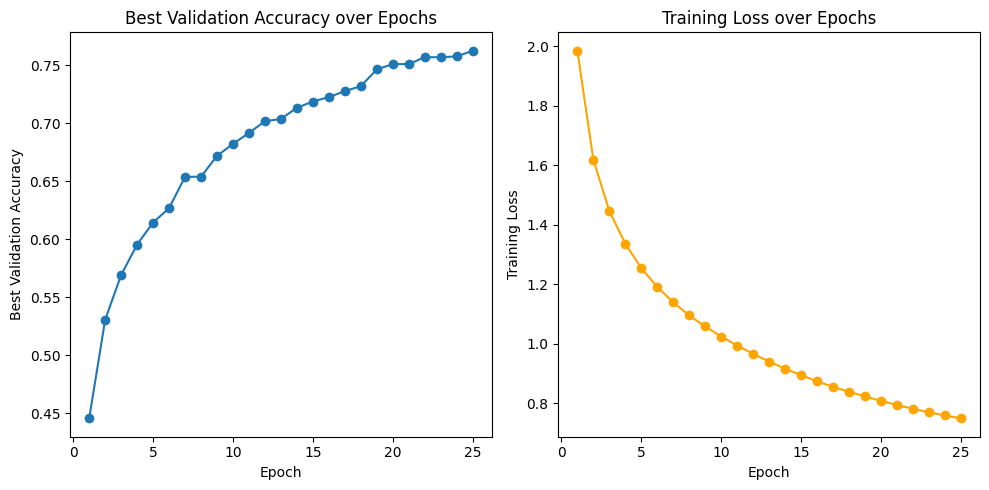

In [ ]:
# Define 1D CNN model
class CNN1DModel(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size, output_size):
        super(CNN1DModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=num_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.max(dim=2)[0]
        output = self.fc(x)
        return output

# Set up your datasets and DataLoader
num_samples, sequence_length, num_features = X_train.shape
input_size = num_features
num_channels = 64
kernel_size = 3
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='cnn')
dataset_valid = CustomDataset(X_valid, y_valid, input_type='cnn')

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize your model, loss function, and optimizer
model = CNN1DModel(input_size=num_features, num_channels=num_channels, kernel_size=kernel_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model state for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for the test set
dataset_test = CustomDataset(X_test, y_test, input_type='cnn')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")

## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

## Weighted

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
# Lets define a function to add inversed weights based on the frequency
def class_frequency(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    frequency_dict = dict(zip(unique_labels, counts))
    total_samples = len(labels)
    class_weights = [total_samples / (frequency_dict[label] * len(unique_labels)) for label in unique_labels]
    return class_weights

### MLP

Epoch 1/25, Loss: 2.2414, Validation Accuracy: 0.6420, Training Time: 2.35 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.81      0.65       813
           1       0.50      0.03      0.06        64
           2       0.81      0.82      0.81      2548
           3       0.76      0.79      0.77      2782
           4       0.15      0.06      0.08       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.44      0.26      0.32      1289
          10       0.54      0.56      0.55       751
          11       0.49      0.89      0.64       586
          12       0.32      0.45      0.37       775
          13       0.05      0.01      0.02        79
          14       0.76      0.61      0.68      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25, Loss: 1.6454, Validation Accuracy: 0.6415, Training Time: 3.17 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73       813
           1       0.28      0.34      0.31        64
           2       0.86      0.78      0.81      2548
           3       0.81      0.65      0.72      2782
           4       0.15      0.34      0.21       308
           5       0.05      0.41      0.09        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.49      0.30      0.37      1289
          10       0.66      0.61      0.63       751
          11       0.67      0.86      0.75       586
          12       0.36      0.42      0.39       775
          13       0.00      0.00      0.00        79
          14       0.70      0.77      0.74      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25, Loss: 1.4460, Validation Accuracy: 0.6594, Training Time: 3.57 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.90      0.76       813
           1       0.25      0.53      0.34        64
           2       0.82      0.85      0.84      2548
           3       0.84      0.67      0.75      2782
           4       0.18      0.15      0.16       308
           5       0.05      0.46      0.10        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.09      0.02      0.03        62
           9       0.56      0.34      0.42      1289
          10       0.64      0.69      0.67       751
          11       0.79      0.84      0.81       586
          12       0.37      0.45      0.41       775
          13       0.07      0.35      0.12        79
          14       0.79      0.65      0.71      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/25, Loss: 1.3444, Validation Accuracy: 0.6325, Training Time: 2.71 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80       813
           1       0.50      0.33      0.40        64
           2       0.79      0.89      0.84      2548
           3       0.88      0.54      0.67      2782
           4       0.17      0.23      0.19       308
           5       0.06      0.47      0.11        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.07      0.19      0.10        62
           9       0.47      0.44      0.45      1289
          10       0.59      0.78      0.67       751
          11       0.76      0.89      0.82       586
          12       0.33      0.63      0.43       775
          13       0.19      0.19      0.19        79
          14       0.91      0.43      0.58      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25, Loss: 1.2862, Validation Accuracy: 0.6632, Training Time: 3.78 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.95      0.78       813
           1       0.22      0.67      0.34        64
           2       0.88      0.74      0.81      2548
           3       0.85      0.60      0.71      2782
           4       0.17      0.38      0.23       308
           5       0.07      0.51      0.12        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.06      0.10      0.07        62
           9       0.49      0.45      0.47      1289
          10       0.65      0.80      0.72       751
          11       0.90      0.81      0.85       586
          12       0.46      0.52      0.49       775
          13       0.21      0.28      0.24        79
          14       0.84      0.72      0.77      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/25, Loss: 1.2356, Validation Accuracy: 0.6532, Training Time: 6.96 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       813
           1       0.21      0.72      0.33        64
           2       0.87      0.78      0.82      2548
           3       0.88      0.51      0.65      2782
           4       0.15      0.19      0.17       308
           5       0.08      0.50      0.13        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.03      0.40      0.06        62
           9       0.53      0.50      0.52      1289
          10       0.72      0.74      0.73       751
          11       0.79      0.90      0.84       586
          12       0.44      0.60      0.51       775
          13       0.23      0.24      0.24        79
          14       0.85      0.70      0.77      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25, Loss: 1.2041, Validation Accuracy: 0.5742, Training Time: 4.93 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       813
           1       0.17      0.81      0.28        64
           2       0.85      0.82      0.83      2548
           3       0.90      0.27      0.41      2782
           4       0.10      0.54      0.16       308
           5       0.15      0.28      0.20        68
           6       0.02      0.10      0.03        10
           7       0.00      0.00      0.00         7
           8       0.04      0.11      0.06        62
           9       0.51      0.51      0.51      1289
          10       0.88      0.56      0.68       751
          11       0.76      0.92      0.83       586
          12       0.43      0.50      0.46       775
          13       0.06      0.63      0.10        79
          14       0.89      0.55      0.68      1982

    accuracy                           0.57     12124
   macro avg       0.44      0.50      0.41  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       813
           1       0.25      0.75      0.38        64
           2       0.87      0.81      0.84      2548
           3       0.86      0.69      0.77      2782
           4       0.20      0.31      0.24       308
           5       0.12      0.35      0.18        68
           6       0.03      0.10      0.04        10
           7       0.00      0.00      0.00         7
           8       0.07      0.19      0.10        62
           9       0.54      0.57      0.55      1289
          10       0.66      0.88      0.76       751
          11       0.75      0.93      0.83       586
          12       0.50      0.55      0.52       775
          13       0.17      0.28      0.21        79
          14       0.89      0.68      0.77      1982

    accuracy                           0.71     12124
   macro avg       0.45      0.53      0.47  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/25, Loss: 1.1135, Validation Accuracy: 0.7011, Training Time: 5.47 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84       813
           1       0.26      0.70      0.38        64
           2       0.87      0.81      0.84      2548
           3       0.89      0.59      0.71      2782
           4       0.17      0.34      0.23       308
           5       0.11      0.37      0.17        68
           6       0.05      0.10      0.06        10
           7       0.00      0.00      0.00         7
           8       0.07      0.24      0.10        62
           9       0.56      0.54      0.55      1289
          10       0.77      0.86      0.81       751
          11       0.77      0.94      0.85       586
          12       0.52      0.58      0.55       775
          13       0.13      0.43      0.21        79
          14       0.84      0.74      0.79      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/25, Loss: 1.0989, Validation Accuracy: 0.6663, Training Time: 4.38 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84       813
           1       0.13      0.88      0.23        64
           2       0.85      0.84      0.85      2548
           3       0.89      0.55      0.68      2782
           4       0.14      0.26      0.19       308
           5       0.12      0.31      0.17        68
           6       0.05      0.20      0.08        10
           7       0.00      0.00      0.00         7
           8       0.05      0.16      0.08        62
           9       0.52      0.51      0.51      1289
          10       0.90      0.64      0.75       751
          11       0.68      0.95      0.79       586
          12       0.56      0.42      0.48       775
          13       0.08      0.63      0.14        79
          14       0.85      0.71      0.77      1982

    accuracy   

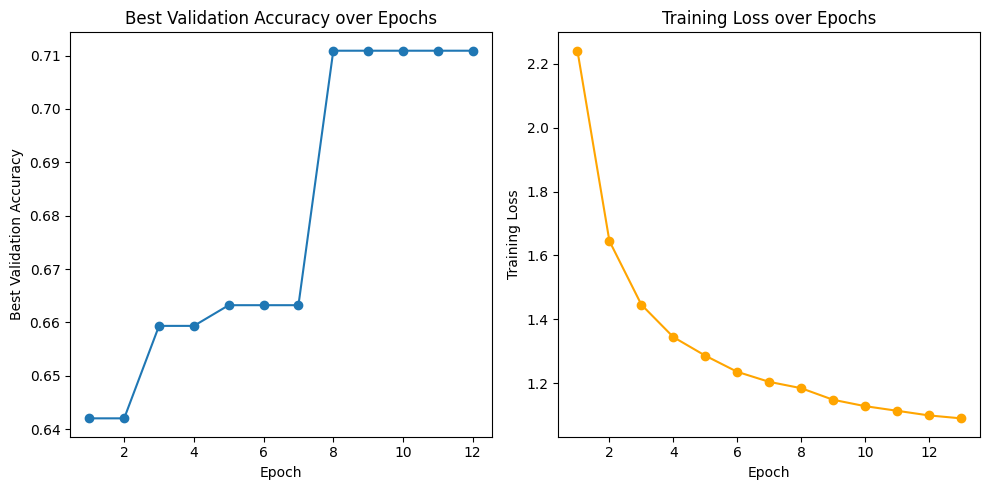

In [ ]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set up datasets and dataloader
num_samples, sequence_length, num_features = X_train.shape
input_size = sequence_length * num_features
hidden_size = 64
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='mlp')  # Adjust input_type as needed
dataset_valid = CustomDataset(X_valid, y_valid, input_type='mlp')  # Adjust input_type as needed

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = MLPModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Set up the loss function with the class weights
class_weights = torch.tensor(class_frequency(y_train), dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model state for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for the test set
dataset_test = CustomDataset(X_test, y_test, input_type='mlp')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")


## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

### RNN

Epoch 1/25, Loss: 2.6438, Validation Accuracy: 0.1919, Training Time: 264.79 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.00      0.00      0.00        64
           2       0.26      0.72      0.39      2548
           3       0.00      0.00      0.00      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.15      0.14      0.15      1289
          10       0.00      0.00      0.00       751
          11       0.07      0.38      0.11       586
          12       0.00      0.00      0.00       775
          13       0.00      0.00      0.00        79
          14       0.14      0.05      0.07      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25, Loss: 2.4459, Validation Accuracy: 0.4664, Training Time: 259.76 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.78      0.55       813
           1       0.08      0.03      0.04        64
           2       0.55      0.75      0.63      2548
           3       0.58      0.62      0.60      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.12      0.01      0.01      1289
          10       0.32      0.76      0.45       751
          11       0.21      0.23      0.22       586
          12       0.13      0.11      0.12       775
          13       0.00      0.00      0.00        79
          14       0.56      0.30      0.39      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25, Loss: 1.8464, Validation Accuracy: 0.4739, Training Time: 260.76 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73       813
           1       0.07      0.59      0.13        64
           2       0.68      0.84      0.75      2548
           3       0.74      0.32      0.45      2782
           4       0.09      0.30      0.14       308
           5       0.19      0.09      0.12        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.26      0.17      0.21      1289
          10       0.53      0.83      0.65       751
          11       0.26      0.42      0.32       586
          12       0.22      0.29      0.25       775
          13       0.00      0.00      0.00        79
          14       0.48      0.29      0.36      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/25, Loss: 1.6532, Validation Accuracy: 0.4933, Training Time: 260.16 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.93      0.74       813
           1       0.14      0.42      0.20        64
           2       0.79      0.79      0.79      2548
           3       0.75      0.43      0.54      2782
           4       0.11      0.31      0.16       308
           5       0.04      0.49      0.08        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.34      0.20      0.25      1289
          10       0.52      0.84      0.64       751
          11       0.25      0.64      0.36       586
          12       0.27      0.33      0.30       775
          13       0.00      0.00      0.00        79
          14       0.76      0.18      0.29      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25, Loss: 1.5622, Validation Accuracy: 0.5195, Training Time: 260.26 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.96      0.74       813
           1       0.05      0.80      0.10        64
           2       0.84      0.76      0.79      2548
           3       0.75      0.37      0.50      2782
           4       0.08      0.19      0.11       308
           5       0.10      0.46      0.16        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.42      0.27      0.33      1289
          10       0.67      0.77      0.72       751
          11       0.28      0.74      0.40       586
          12       0.33      0.30      0.31       775
          13       0.04      0.01      0.02        79
          14       0.74      0.42      0.54      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/25, Loss: 1.4271, Validation Accuracy: 0.6123, Training Time: 257.79 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       813
           1       0.12      0.72      0.21        64
           2       0.88      0.61      0.72      2548
           3       0.69      0.72      0.71      2782
           4       0.15      0.36      0.21       308
           5       0.10      0.49      0.17        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.35      0.36      0.36      1289
          10       0.83      0.70      0.76       751
          11       0.64      0.80      0.71       586
          12       0.39      0.36      0.37       775
          13       0.00      0.00      0.00        79
          14       0.74      0.63      0.68      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25, Loss: 1.3651, Validation Accuracy: 0.6697, Training Time: 255.65 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       813
           1       0.26      0.52      0.34        64
           2       0.83      0.79      0.81      2548
           3       0.85      0.69      0.77      2782
           4       0.20      0.24      0.22       308
           5       0.14      0.44      0.22        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.45      0.37      0.40      1289
          10       0.71      0.86      0.78       751
          11       0.64      0.93      0.75       586
          12       0.34      0.59      0.43       775
          13       0.00      0.00      0.00        79
          14       0.76      0.58      0.66      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/25, Loss: 1.3106, Validation Accuracy: 0.6574, Training Time: 256.79 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79       813
           1       0.16      0.72      0.26        64
           2       0.83      0.79      0.81      2548
           3       0.86      0.68      0.76      2782
           4       0.15      0.34      0.21       308
           5       0.13      0.46      0.20        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.44      0.34      0.38      1289
          10       0.64      0.89      0.75       751
          11       0.54      0.93      0.68       586
          12       0.39      0.44      0.41       775
          13       0.11      0.05      0.07        79
          14       0.81      0.63      0.71      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/25, Loss: 1.2482, Validation Accuracy: 0.6704, Training Time: 258.24 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81       813
           1       0.15      0.72      0.25        64
           2       0.85      0.75      0.80      2548
           3       0.87      0.62      0.72      2782
           4       0.14      0.31      0.19       308
           5       0.11      0.51      0.18        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.02      0.03      0.03        62
           9       0.47      0.38      0.42      1289
          10       0.76      0.85      0.80       751
          11       0.85      0.85      0.85       586
          12       0.43      0.56      0.49       775
          13       0.09      0.11      0.10        79
          14       0.82      0.75      0.78      1982

    accuracy  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/25, Loss: 1.2237, Validation Accuracy: 0.6945, Training Time: 255.88 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83       813
           1       0.23      0.66      0.34        64
           2       0.87      0.73      0.79      2548
           3       0.85      0.78      0.81      2782
           4       0.21      0.31      0.25       308
           5       0.12      0.51      0.19        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.03      0.02      0.02        62
           9       0.51      0.41      0.45      1289
          10       0.66      0.91      0.77       751
          11       0.79      0.89      0.83       586
          12       0.43      0.59      0.49       775
          13       0.11      0.28      0.16        79
          14       0.87      0.64      0.73      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/25, Loss: 1.1958, Validation Accuracy: 0.6364, Training Time: 256.77 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       813
           1       0.18      0.67      0.28        64
           2       0.86      0.78      0.81      2548
           3       0.87      0.48      0.62      2782
           4       0.12      0.45      0.19       308
           5       0.07      0.37      0.12        68
           6       0.02      0.20      0.04        10
           7       0.00      0.00      0.00         7
           8       0.02      0.02      0.02        62
           9       0.55      0.47      0.51      1289
          10       0.64      0.91      0.76       751
          11       0.81      0.89      0.85       586
          12       0.41      0.65      0.50       775
          13       0.09      0.18      0.12        79
          14       0.89      0.59      0.71      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/25, Loss: 1.1690, Validation Accuracy: 0.6231, Training Time: 256.59 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84       813
           1       0.23      0.67      0.34        64
           2       0.85      0.75      0.80      2548
           3       0.90      0.57      0.70      2782
           4       0.16      0.36      0.22       308
           5       0.09      0.40      0.15        68
           6       0.03      0.20      0.05        10
           7       0.00      0.00      0.00         7
           8       0.01      0.02      0.01        62
           9       0.45      0.47      0.46      1289
          10       0.81      0.84      0.82       751
          11       0.73      0.93      0.82       586
          12       0.36      0.70      0.48       775
          13       0.06      0.32      0.09        79
          14       0.85      0.39      0.53      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/25, Loss: 1.1566, Validation Accuracy: 0.6750, Training Time: 255.85 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84       813
           1       0.21      0.70      0.33        64
           2       0.86      0.75      0.80      2548
           3       0.89      0.56      0.68      2782
           4       0.14      0.43      0.21       308
           5       0.09      0.63      0.15        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.53      0.51      0.52      1289
          10       0.92      0.61      0.73       751
          11       0.83      0.92      0.87       586
          12       0.46      0.67      0.54       775
          13       0.07      0.08      0.08        79
          14       0.83      0.78      0.81      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/25, Loss: 1.1393, Validation Accuracy: 0.6538, Training Time: 257.70 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       813
           1       0.24      0.64      0.35        64
           2       0.88      0.72      0.79      2548
           3       0.87      0.49      0.63      2782
           4       0.11      0.50      0.19       308
           5       0.10      0.40      0.16        68
           6       0.03      0.20      0.05        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.48      0.55      0.51      1289
          10       0.85      0.81      0.83       751
          11       0.94      0.78      0.85       586
          12       0.45      0.70      0.55       775
          13       0.13      0.20      0.16        79
          14       0.86      0.71      0.78      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/25, Loss: 1.1132, Validation Accuracy: 0.6777, Training Time: 257.58 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       813
           1       0.22      0.75      0.34        64
           2       0.87      0.74      0.80      2548
           3       0.89      0.57      0.69      2782
           4       0.14      0.28      0.18       308
           5       0.08      0.54      0.13        68
           6       0.09      0.10      0.10        10
           7       0.00      0.00      0.00         7
           8       0.04      0.15      0.06        62
           9       0.55      0.54      0.54      1289
          10       0.88      0.75      0.81       751
          11       0.92      0.77      0.83       586
          12       0.49      0.62      0.54       775
          13       0.08      0.30      0.13        79
          14       0.82      0.81      0.82      1982

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test Results
Test Accuracy: 0.6859
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86       401
           1       0.24      0.90      0.38        31
           2       0.88      0.73      0.80      1255
           3       0.91      0.56      0.69      1370
           4       0.19      0.38      0.26       152
           5       0.08      0.62      0.14        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.02      0.10      0.04        31
           9       0.55      0.55      0.55       635
          10       0.89      0.77      0.83       370
          11       0.91      0.82      0.86       289
          12       0.51      0.60      0.55       382
          13       0.05      0.18      0.08        38
          14       0.83      0.83      0.83       976

    accuracy                           0.69      5972
   macro avg    

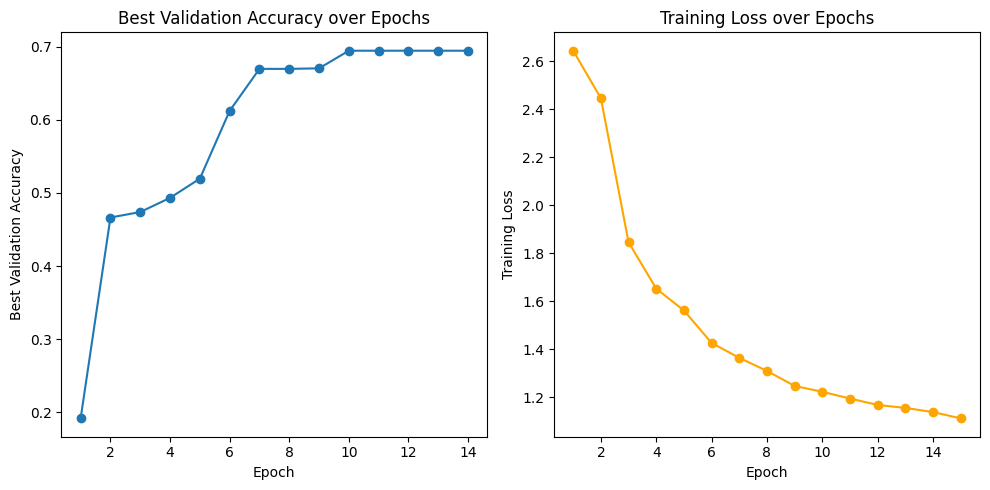

In [ ]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use only the output from the last time step
        return output

# Set up datasets and DataLoader
num_samples, sequence_length, num_features = X_train.shape
input_size = num_samples
hidden_size = 64
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='rnn')
dataset_valid = CustomDataset(X_valid, y_valid, input_type='rnn')

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize your model, loss function, and optimizer
model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=1, output_size=output_size)
# Set up the loss function with the class weights
class_weights = torch.tensor(class_frequency(y_train), dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model state for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for the test set
dataset_test = CustomDataset(X_test, y_test, input_type='rnn')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")

## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

### 1D CNN

Epoch 1/50, Loss: 2.5810, Validation Accuracy: 0.4201, Training Time: 5.33 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.65      0.31       813
           1       0.00      0.00      0.00        64
           2       0.58      0.84      0.68      2548
           3       0.50      0.46      0.48      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.11      0.00      0.00      1289
          10       0.00      0.00      0.00       751
          11       0.22      0.59      0.32       586
          12       0.21      0.04      0.07       775
          13       0.00      0.00      0.00        79
          14       0.49      0.39      0.43      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/50, Loss: 2.3172, Validation Accuracy: 0.4386, Training Time: 6.58 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.59      0.42       813
           1       0.00      0.00      0.00        64
           2       0.61      0.82      0.70      2548
           3       0.69      0.21      0.32      2782
           4       0.07      0.24      0.11       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.21      0.20      0.20      1289
          10       0.43      0.31      0.36       751
          11       0.70      0.29      0.41       586
          12       0.21      0.23      0.22       775
          13       0.00      0.00      0.00        79
          14       0.50      0.63      0.56      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/50, Loss: 2.1264, Validation Accuracy: 0.5091, Training Time: 5.29 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.58      0.43       813
           1       0.12      0.14      0.13        64
           2       0.70      0.82      0.75      2548
           3       0.67      0.42      0.52      2782
           4       0.00      0.00      0.00       308
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.31      0.10      0.15      1289
          10       0.47      0.25      0.33       751
          11       0.56      0.68      0.61       586
          12       0.21      0.39      0.27       775
          13       0.00      0.00      0.00        79
          14       0.48      0.72      0.58      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/50, Loss: 1.9942, Validation Accuracy: 0.4829, Training Time: 6.69 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.61      0.45       813
           1       0.14      0.28      0.19        64
           2       0.74      0.85      0.79      2548
           3       0.76      0.12      0.21      2782
           4       0.08      0.36      0.14       308
           5       0.09      0.12      0.10        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.31      0.15      0.20      1289
          10       0.38      0.49      0.43       751
          11       0.57      0.88      0.69       586
          12       0.28      0.21      0.24       775
          13       0.00      0.00      0.00        79
          14       0.55      0.75      0.63      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/50, Loss: 1.8874, Validation Accuracy: 0.5120, Training Time: 6.02 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.65      0.46       813
           1       0.11      0.30      0.17        64
           2       0.74      0.87      0.80      2548
           3       0.75      0.20      0.32      2782
           4       0.08      0.32      0.13       308
           5       0.08      0.18      0.11        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.30      0.20      0.24      1289
          10       0.56      0.38      0.46       751
          11       0.65      0.90      0.75       586
          12       0.31      0.29      0.30       775
          13       0.05      0.09      0.06        79
          14       0.62      0.73      0.67      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/50, Loss: 1.8013, Validation Accuracy: 0.5502, Training Time: 6.69 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.66      0.49       813
           1       0.23      0.27      0.24        64
           2       0.82      0.81      0.81      2548
           3       0.79      0.31      0.45      2782
           4       0.13      0.16      0.14       308
           5       0.09      0.31      0.13        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.32      0.30      0.31      1289
          10       0.39      0.68      0.49       751
          11       0.84      0.85      0.84       586
          12       0.30      0.41      0.35       775
          13       0.00      0.00      0.00        79
          14       0.64      0.72      0.67      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/50, Loss: 1.7277, Validation Accuracy: 0.5692, Training Time: 5.17 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.64      0.54       813
           1       0.16      0.31      0.22        64
           2       0.81      0.83      0.82      2548
           3       0.78      0.42      0.55      2782
           4       0.14      0.13      0.13       308
           5       0.06      0.26      0.10        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.02      0.02      0.02        62
           9       0.32      0.28      0.30      1289
          10       0.61      0.45      0.52       751
          11       0.90      0.82      0.86       586
          12       0.31      0.43      0.36       775
          13       0.06      0.39      0.10        79
          14       0.64      0.74      0.69      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/50, Loss: 1.6674, Validation Accuracy: 0.5892, Training Time: 3.53 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.70      0.58       813
           1       0.10      0.50      0.17        64
           2       0.84      0.77      0.80      2548
           3       0.77      0.48      0.59      2782
           4       0.13      0.12      0.12       308
           5       0.07      0.34      0.11        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.38      0.23      0.29      1289
          10       0.55      0.56      0.55       751
          11       0.79      0.91      0.84       586
          12       0.32      0.43      0.37       775
          13       0.33      0.01      0.02        79
          14       0.60      0.82      0.69      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/50, Loss: 1.6143, Validation Accuracy: 0.6092, Training Time: 3.80 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.74      0.57       813
           1       0.09      0.56      0.16        64
           2       0.81      0.84      0.82      2548
           3       0.79      0.51      0.62      2782
           4       0.15      0.04      0.06       308
           5       0.11      0.24      0.15        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.02      0.03      0.03        62
           9       0.35      0.27      0.30      1289
          10       0.54      0.65      0.59       751
          11       0.84      0.92      0.88       586
          12       0.35      0.55      0.43       775
          13       0.11      0.08      0.09        79
          14       0.72      0.69      0.71      1982

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/50, Loss: 1.5715, Validation Accuracy: 0.5944, Training Time: 4.74 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.78      0.59       813
           1       0.09      0.59      0.16        64
           2       0.82      0.81      0.82      2548
           3       0.81      0.43      0.57      2782
           4       0.15      0.09      0.11       308
           5       0.06      0.38      0.10        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.05      0.02      0.02        62
           9       0.39      0.24      0.30      1289
          10       0.47      0.72      0.57       751
          11       0.85      0.92      0.89       586
          12       0.38      0.39      0.39       775
          13       0.09      0.19      0.12        79
          14       0.69      0.76      0.72      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/50, Loss: 1.5329, Validation Accuracy: 0.6241, Training Time: 3.56 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.76      0.63       813
           1       0.19      0.33      0.24        64
           2       0.80      0.87      0.83      2548
           3       0.77      0.51      0.61      2782
           4       0.11      0.26      0.16       308
           5       0.08      0.34      0.13        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        62
           9       0.40      0.27      0.32      1289
          10       0.60      0.63      0.61       751
          11       0.85      0.94      0.89       586
          12       0.42      0.46      0.44       775
          13       0.13      0.30      0.18        79
          14       0.75      0.73      0.74      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/50, Loss: 1.5007, Validation Accuracy: 0.6060, Training Time: 3.48 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.77      0.62       813
           1       0.21      0.28      0.24        64
           2       0.81      0.84      0.83      2548
           3       0.81      0.41      0.55      2782
           4       0.12      0.26      0.16       308
           5       0.10      0.25      0.15        68
           6       0.25      0.10      0.14        10
           7       0.00      0.00      0.00         7
           8       0.02      0.10      0.03        62
           9       0.39      0.32      0.35      1289
          10       0.53      0.70      0.61       751
          11       0.90      0.92      0.91       586
          12       0.39      0.54      0.45       775
          13       0.16      0.18      0.17        79
          14       0.77      0.70      0.73      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/50, Loss: 1.4652, Validation Accuracy: 0.6206, Training Time: 4.64 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.78      0.62       813
           1       0.17      0.52      0.26        64
           2       0.81      0.86      0.83      2548
           3       0.82      0.45      0.58      2782
           4       0.13      0.17      0.15       308
           5       0.12      0.18      0.14        68
           6       0.10      0.20      0.13        10
           7       0.00      0.00      0.00         7
           8       0.03      0.03      0.03        62
           9       0.37      0.35      0.36      1289
          10       0.62      0.63      0.63       751
          11       0.95      0.92      0.93       586
          12       0.39      0.55      0.46       775
          13       0.10      0.38      0.16        79
          14       0.73      0.73      0.73      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/50, Loss: 1.4464, Validation Accuracy: 0.6306, Training Time: 3.71 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68       813
           1       0.10      0.66      0.17        64
           2       0.81      0.85      0.83      2548
           3       0.81      0.50      0.61      2782
           4       0.13      0.18      0.15       308
           5       0.09      0.28      0.14        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.03      0.06      0.04        62
           9       0.43      0.28      0.34      1289
          10       0.63      0.66      0.64       751
          11       0.85      0.96      0.90       586
          12       0.40      0.59      0.47       775
          13       0.15      0.27      0.19        79
          14       0.76      0.73      0.74      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/50, Loss: 1.4115, Validation Accuracy: 0.5670, Training Time: 3.47 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.79      0.67       813
           1       0.14      0.56      0.22        64
           2       0.82      0.83      0.83      2548
           3       0.87      0.24      0.37      2782
           4       0.14      0.14      0.14       308
           5       0.06      0.38      0.10        68
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7
           8       0.02      0.39      0.03        62
           9       0.43      0.30      0.36      1289
          10       0.67      0.65      0.66       751
          11       0.94      0.92      0.93       586
          12       0.40      0.59      0.48       775
          13       0.15      0.30      0.21        79
          14       0.78      0.72      0.75      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/50, Loss: 1.3954, Validation Accuracy: 0.6448, Training Time: 3.87 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68       813
           1       0.15      0.59      0.24        64
           2       0.82      0.84      0.83      2548
           3       0.81      0.52      0.63      2782
           4       0.17      0.10      0.13       308
           5       0.06      0.34      0.10        68
           6       0.07      0.10      0.08        10
           7       0.00      0.00      0.00         7
           8       0.04      0.08      0.05        62
           9       0.38      0.40      0.39      1289
          10       0.69      0.65      0.67       751
          11       0.95      0.92      0.93       586
          12       0.47      0.47      0.47       775
          13       0.14      0.25      0.18        79
          14       0.75      0.79      0.77      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/50, Loss: 1.3716, Validation Accuracy: 0.6195, Training Time: 4.48 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.79      0.73       813
           1       0.20      0.41      0.26        64
           2       0.84      0.81      0.82      2548
           3       0.80      0.44      0.57      2782
           4       0.13      0.38      0.19       308
           5       0.09      0.28      0.13        68
           6       0.20      0.10      0.13        10
           7       0.00      0.00      0.00         7
           8       0.02      0.19      0.04        62
           9       0.41      0.39      0.40      1289
          10       0.65      0.69      0.67       751
          11       0.93      0.94      0.93       586
          12       0.50      0.44      0.47       775
          13       0.13      0.41      0.20        79
          14       0.81      0.73      0.77      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/50, Loss: 1.3542, Validation Accuracy: 0.6276, Training Time: 3.50 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73       813
           1       0.11      0.64      0.18        64
           2       0.82      0.86      0.84      2548
           3       0.82      0.42      0.55      2782
           4       0.12      0.33      0.18       308
           5       0.09      0.28      0.13        68
           6       1.00      0.10      0.18        10
           7       0.00      0.00      0.00         7
           8       0.05      0.11      0.07        62
           9       0.41      0.40      0.40      1289
          10       0.72      0.65      0.69       751
          11       0.89      0.96      0.92       586
          12       0.43      0.62      0.51       775
          13       0.16      0.34      0.22        79
          14       0.80      0.72      0.76      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/50, Loss: 1.3431, Validation Accuracy: 0.6042, Training Time: 3.48 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.80      0.68       813
           1       0.18      0.59      0.27        64
           2       0.81      0.87      0.84      2548
           3       0.86      0.34      0.48      2782
           4       0.14      0.19      0.16       308
           5       0.09      0.19      0.13        68
           6       0.06      0.20      0.09        10
           7       0.00      0.00      0.00         7
           8       0.04      0.16      0.06        62
           9       0.36      0.46      0.40      1289
          10       0.66      0.67      0.66       751
          11       0.93      0.94      0.94       586
          12       0.37      0.68      0.48       775
          13       0.13      0.43      0.21        79
          14       0.82      0.61      0.70      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/50, Loss: 1.3112, Validation Accuracy: 0.6371, Training Time: 3.55 seconds
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75       813
           1       0.11      0.64      0.18        64
           2       0.83      0.84      0.83      2548
           3       0.83      0.43      0.56      2782
           4       0.12      0.31      0.18       308
           5       0.07      0.26      0.11        68
           6       0.06      0.10      0.07        10
           7       0.00      0.00      0.00         7
           8       0.04      0.06      0.05        62
           9       0.46      0.38      0.41      1289
          10       0.80      0.59      0.68       751
          11       0.90      0.96      0.93       586
          12       0.43      0.58      0.49       775
          13       0.12      0.25      0.16        79
          14       0.72      0.83      0.78      1982

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Test Results
Test Accuracy: 0.6445
Test Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77       401
           1       0.14      0.77      0.24        31
           2       0.84      0.84      0.84      1255
           3       0.84      0.42      0.55      1370
           4       0.13      0.34      0.19       152
           5       0.11      0.41      0.18        34
           6       0.14      0.25      0.18         4
           7       0.00      0.00      0.00         4
           8       0.06      0.06      0.06        31
           9       0.47      0.38      0.42       635
          10       0.78      0.65      0.71       370
          11       0.89      0.99      0.94       289
          12       0.44      0.55      0.49       382
          13       0.14      0.26      0.18        38
          14       0.71      0.84      0.77       976

    accuracy                           0.64      5972
   macro avg    

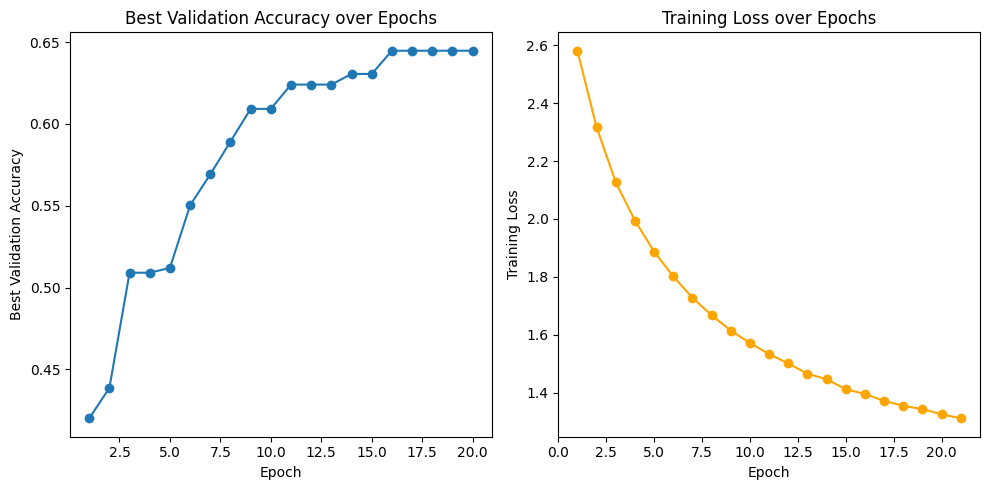

In [ ]:
# Define 1D CNN model
class CNN1DModel(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size, output_size):
        super(CNN1DModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=num_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.max(dim=2)[0]
        output = self.fc(x)
        return output

# Set up your datasets and DataLoader
num_samples, sequence_length, num_features = X_train.shape
input_size = num_features
num_channels = 64
kernel_size = 3
output_size = len(np.unique(y_train))

dataset_train = CustomDataset(X_train, y_train, input_type='cnn')
dataset_valid = CustomDataset(X_valid, y_valid, input_type='cnn')

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

# Initialize your model, loss function, and optimizer
model = CNN1DModel(input_size=num_features, num_channels=num_channels, kernel_size=kernel_size, output_size=output_size)
# Set up the loss function with the class weights
class_weights = torch.tensor(class_frequency(y_train), dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_accuracy = 0.0
best_val_accuracies = []
train_losses = []

best_model_state_dict = None

early_stopping_patience = 5
early_stopping_counter = 0
stopped_epoch = None

for epoch in range(num_epochs):
    model.train()

    start_time = time.time()

    epoch_loss = 0.0

    for batch in train_dataloader:
        data = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)

    end_time = time.time()

    training_time = end_time - start_time

    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []

    with torch.no_grad():
        for batch in valid_dataloader:
            data = batch['data']
            labels = batch['label']

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds')

    # Save the model if it achieves a new best validation accuracy
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    best_val_accuracies.append(best_val_accuracy)

    val_classification_report = classification_report(y_valid, all_predictions)
    f1_macro = f1_score(y_valid, all_predictions, average='macro')
    f1_micro = f1_score(y_valid, all_predictions, average='micro')

    print("Validation Classification Report:\n", val_classification_report)
    print(f"Overall F1 Score (Macro): {f1_macro:.4f}")
    print(f"Overall F1 Score (Micro): {f1_micro:.4f}")

    # Check for early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement.')
        stopped_epoch = epoch + 1
        break

# Load the best model state for testing
model.load_state_dict(best_model_state_dict)

# Create a DataLoader for the test set
dataset_test = CustomDataset(X_test, y_test, input_type='cnn')
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()
total_correct_test = 0
total_samples_test = 0
all_predictions_test = []

with torch.no_grad():
    for batch in test_dataloader:
        data = batch['data']
        labels = batch['label']

        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        total_correct_test += (predictions == labels).sum().item()
        total_samples_test += labels.size(0)

        all_predictions_test.extend(predictions.cpu().numpy())

# Calculate and print metrics for the test set
accuracy_test = total_correct_test / total_samples_test
test_classification_report = classification_report(y_test, all_predictions_test)
f1_macro_test = f1_score(y_test, all_predictions_test, average='macro')
f1_micro_test = f1_score(y_test, all_predictions_test, average='micro')

print('=' * 80)
print("Test Results")
print('=' * 80)
print(f'Test Accuracy: {accuracy_test:.4f}')
print("Test Classification Report:\n", test_classification_report)
print(f"Overall F1 Score (Macro) on Test Set: {f1_macro_test:.4f}")
print(f"Overall F1 Score (Micro) on Test Set: {f1_micro_test:.4f}")

## Plot loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs_to_plot = range(1, stopped_epoch) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, best_val_accuracies[:len(epochs_to_plot)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy over Epochs')

plt.subplot(1, 2, 2)
epochs_to_plot = range(1, stopped_epoch + 1) if stopped_epoch else range(1, num_epochs + 1)
plt.plot(epochs_to_plot, train_losses[:len(epochs_to_plot)], marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.tight_layout()
plt.show()

# Results

Table below shows
  - Micro F1 score which is weighted average of accuracy of all classes based on their presence in the dataset.
  - Macro F1 score which is average accuracy of all classes regardles of the number of their samples.
  - Accuracy is the same as Micro F1 score but calculated slightly differently (using all the samples and not just by averaging final F1 accuracies)

Generally, idea of handling class imbalance did not work. There is more information in the printed statments from the training. We can see there that some classes indeed imporved their accuracy with weights added to the cost function, especally classes with less than 100 samples, but it was not significant. On top of that, classes that were doing pretty well without weights had significantly lower accuracy, which makes sense knowing the scale of the samples - classes with the most samples had weight almost 1000 times less than the class with lowest number of sample. This proves that the size of the datasets plays the crucial role when it comes to training deep learning model.

Interestingly, MLP has shown the highest overall accuracy (even slightly higher than RNN), thus flattening the dataset and losing time variable was not an issue. The print statement below shows accuracy metrics for unweighted MLP and unweighted RNN.

In [ ]:
import pandas as pd

model_names = ['MLP', 'RNN', 'CNN', 'MLP (Weighted)', 'RNN (Weighted)', 'CNN (Weighted)']
micro_f1_scores = [0.84, 0.83, 0.77, 0.67, 0.69, 0.64]
macro_f1_scores = [0.53, 0.51, 0.42, 0.47, 0.46, 0.43]
accuracy_scores = [0.82, 0.81, 0.75, 0.70, 0.72, 0.65]

data = {'Model': model_names, 'Micro F1 Score': micro_f1_scores, 'Macro F1 Score': macro_f1_scores, 'Overall Accuracy': accuracy_scores}
df = pd.DataFrame(data)
print("                ================RESULTS===============")
print(df)


              ================RESULTS===============
            Model  Micro F1 Score  Macro F1 Score  Overall Accuracy
0             MLP            0.84            0.53              0.82
1             RNN            0.83            0.51              0.81
2             CNN            0.77            0.42              0.75
3  MLP (Weighted)            0.67            0.47              0.70
4  RNN (Weighted)            0.69            0.46              0.72
5  CNN (Weighted)            0.64            0.43              0.65


In [ ]:
import pandas as pd

classification_report_str = """

            ===========  MLP  ===========

               precision    recall  f1-score   support

           0       0.96      0.89      0.93       401
           1       0.73      0.35      0.48        31
           2       0.85      0.92      0.89      1255
           3       0.82      0.93      0.87      1370
           4       0.46      0.08      0.13       152
           5       0.67      0.12      0.20        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.73      0.66      0.69       635
          10       0.80      0.97      0.88       370
          11       0.95      0.97      0.96       289
          12       0.83      0.65      0.73       382
          13       0.86      0.16      0.27        38
          14       0.88      0.92      0.90       976

    accuracy                           0.84      5972
   macro avg       0.64      0.51      0.53      5972
weighted avg       0.83      0.84      0.82      5972

            ===========  RNN  ===========

               precision    recall  f1-score   support

           0       0.90      0.96      0.93       401
           1       0.73      0.61      0.67        31
           2       0.82      0.95      0.88      1255
           3       0.83      0.93      0.88      1370
           4       0.65      0.17      0.27       152
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.80      0.57      0.66       635
          10       0.84      0.95      0.90       370
          11       0.99      0.78      0.87       289
          12       0.62      0.78      0.69       382
          13       0.00      0.00      0.00        38
          14       0.89      0.84      0.87       976

    accuracy                           0.83      5972
   macro avg       0.54      0.50      0.51      5972
weighted avg       0.81      0.83      0.81      5972
"""
print(classification_report_str)



            ===========  MLP  ===========

               precision    recall  f1-score   support

           0       0.96      0.89      0.93       401
           1       0.73      0.35      0.48        31
           2       0.85      0.92      0.89      1255
           3       0.82      0.93      0.87      1370
           4       0.46      0.08      0.13       152
           5       0.67      0.12      0.20        34
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31
           9       0.73      0.66      0.69       635
          10       0.80      0.97      0.88       370
          11       0.95      0.97      0.96       289
          12       0.83      0.65      0.73       382
          13       0.86      0.16      0.27        38
          14       0.88      0.92      0.90       976

    accuracy                           0.84      5972
   macro avg       0.64      0.51 